In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from xgboost import plot_importance

from imblearn.over_sampling import RandomOverSampler 

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection._split import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Criação das funções para viabilizar a aplicação do modelo:

#### Função para instanciar o modelo:

In [2]:
import xgboost as xgb


def instantiate_XGBoost_model (X_train, y_train):
    param_grid = {
        "max_depth": [3, 5, 7],
        #"learning_rate": [0.1, 0.2],
        "gamma": [0.25, 1],
        #"reg_lambda": [0, 1, 10],
        "scale_pos_weight": [1, 3, 5],
        #"subsample": [0.8],
        "colsample_bytree": [0.5, 0.9] }

    # Init classifier
    xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs = -1, cv=5, scoring = "roc_auc")

    # Fit 
    _ = grid_cv.fit(X_train, y_train)

    mean_test_score = grid_cv.cv_results_['mean_test_score'].mean()
    std_test_score = grid_cv.cv_results_['std_test_score'].mean()
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    #print('')

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score'].mean()}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score'].mean()}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return mean_test_score, std_test_score, best_score, best_params

#### Criação de uma função para predição do classificador final:

In [3]:
import xgboost as xgb

def create_final_cl(X_over, y_over, X_test, y_test, colsample_bytree, gamma, max_depth, scale_pos_weight):

    result_f1 = []
    result_precision = []

    # parametrizando o modelo final
    final_cl = xgb.XGBClassifier(colsample_bytree = colsample_bytree, gamma = gamma, max_depth = max_depth, scale_pos_weight = scale_pos_weight)
    #treinando o modelo final
    final_cl.fit(X_over, y_over)
    preds = final_cl.predict(X_test)
    accuracy_score(y_test, preds)

    print('accuracy_score:', accuracy_score(y_test, preds))
    print('#'*40)

    print('"""Métricas f1_score:"""')
    print('f1: ', f1_score(y_test, preds))
    print('Macro: ', f1_score(y_test, preds, average='macro'))
    print('Micro: ', f1_score(y_test, preds, average='micro'))
    print('weighted: ', f1_score(y_test, preds, average='micro'))
    print('#'*40)

    print('"""Métricas precision_score:"""')
    print('Precision: ', precision_score(y_test, preds))
    print('Macro: ', precision_score(y_test, preds, average='macro'))
    print('Micro: ', precision_score(y_test, preds, average='micro'))
    print('weighted: ', precision_score(y_test, preds, average='weighted'))

    result_f1.append(f1_score(y_test, preds))
    result_f1.append(f1_score(y_test, preds, average='macro'))
    result_f1.append(f1_score(y_test, preds, average='micro'))
    result_f1.append(f1_score(y_test, preds, average='micro'))

    result_precision.append(precision_score(y_test, preds))
    result_precision.append(precision_score(y_test, preds, average='macro'))
    result_precision.append(precision_score(y_test, preds, average='micro'))
    result_precision.append(precision_score(y_test, preds, average='weighted'))
    

    #result_f1.append([f1_score(y_test, preds),f1_score(y_test, preds, average='macro'),f1_score(y_test, preds, average='micro'),f1_score(y_test, preds, average='weighted')])
    #result_precision.append([precision_score(y_test, preds), precision_score(y_test, preds, average='macro'),precision_score(y_test, preds, average='micro'), precision_score(y_test, preds, average='weighted')])

    return preds, final_cl, result_f1, result_precision

#### Criação de funções para plotagem de métricas:

In [4]:
def plot_conf_matrix (X_test, y_test, preds, final_cl):

    confusion_matrix(y_test, preds)
    matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    print(classification_report(y_test, preds))


def plot_roc_curve(y_test, preds):
    
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

def plot_feature_importance(final_cl):
    # plot feature importance
    plt.figure(figsize=(14,14))
    plot_importance(final_cl)
    plt.show()

#### Criação de uma função para aplicar o modelo para o período de tempo escolhido:

In [5]:
def apply_periodos (d, df):
    results_f1 = []
    results_precision = []

    if d == 90:
        for i in range (0,758,30):
        
            #treino!
            data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
            data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
            data_fim = data_inicio + pd.Timedelta(days = d)
            
            treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
            X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
            y_train = treino['death']

            #teste!
            teste = df[(df['data_notificacao'] > data_fim_treino) & (df['data_notificacao'] <= data_fim )]
            X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
            y_test = teste['death']

            oversample = RandomOverSampler(sampling_strategy='minority')
            X_over, y_over = oversample.fit_resample(X_train, y_train)

            print('Início do período: ', data_inicio)
            print('Final do período: ', data_fim)

            ####################################################
            #              APLICANDO O MODELO                  #
            ####################################################

            list_random_states = [42]
            #list_random_states = [0,12,42,50,54,68,79,81,92,112]

            mean_test_scores = []
            std_test_scores = []
            best_scores = []
            best_params = []

            for random_state in list_random_states:

                mean_test_score, std_test_score, best_score, best_param = instantiate_XGBoost_model(X_over, y_over)

                mean_test_scores.append(mean_test_score)
                std_test_scores.append(std_test_score)
                best_scores.append(best_score)
                best_params.append(best_param)

            idx = best_scores.index(max(best_scores))
            best_param = best_params[idx]
            #preds, final_cl  = create_final_cl(X_over, y_over, X_test, y_test, best_param['colsample_bytree'], best_param['gamma'], best_param['max_depth'], best_param['scale_pos_weight'])

            preds, final_cl, result_f1, result_precision  = create_final_cl(X_over, y_over, X_test, y_test, best_param['colsample_bytree'], best_param['gamma'], best_param['max_depth'], best_param['scale_pos_weight'])
            results_f1.append(result_f1)
            results_precision.append(result_precision)
            plot_conf_matrix (X_test, y_test, preds, final_cl)

            plot_roc_curve(y_test, preds)

            plot_feature_importance(final_cl)

        return results_f1, results_precision

    if d==120:

            for i in range (0,728,30):
    
                #treino!
                data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
                data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
                data_fim = data_inicio + pd.Timedelta(days = d)
        
                treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
                X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
                y_train = treino['death']

                #teste!
                teste = df[(df['data_notificacao'] > data_fim_treino) & (df['data_notificacao'] <= data_fim )]
                X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
                y_test = teste['death']

                oversample = RandomOverSampler(sampling_strategy='minority')
                X_over, y_over = oversample.fit_resample(X_train, y_train)

                print('Início do período: ', data_inicio)
                print('Final do período: ', data_fim)

                ####################################################
                #              APLICANDO O MODELO                  #
                ####################################################

                list_random_states = [42]
                #list_random_states = [0,12,42,50,54,68,79,81,92,112]

                mean_test_scores = []
                std_test_scores = []
                best_scores = []
                best_params = []

                for random_state in list_random_states:

                    mean_test_score, std_test_score, best_score, best_param = instantiate_XGBoost_model(X_over, y_over)

                    mean_test_scores.append(mean_test_score)
                    std_test_scores.append(std_test_score)
                    best_scores.append(best_score)
                    best_params.append(best_param)

                idx = best_scores.index(max(best_scores))
                best_param = best_params[idx]
                preds, final_cl, result_f1, result_precision  = create_final_cl(X_over, y_over, X_test, y_test, best_param['colsample_bytree'], best_param['gamma'], best_param['max_depth'], best_param['scale_pos_weight'])

                results_f1.append(result_f1)
                results_precision.append(result_precision)
                plot_conf_matrix (X_test, y_test, preds, final_cl)

                plot_roc_curve(y_test, preds)

                plot_feature_importance(final_cl)

            return results_f1, results_precision

## Lendo o dataset:

In [6]:
df = pd.read_csv('..\Data\Casos Graves\df_casos_graves')

### Utilizando a class de pré-processamento para preparar o dataset:

In [7]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']

In [8]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])
df = df.sort_values(by='data_notificacao', ascending=True)
df = df.reset_index()
df = df.drop("index", axis=1)
df

C:\Users\maril\AppData\Local\Temp\ipykernel_27872\3432879523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])


SYMPTOM_COUGH  SYMPTOM_COLD  SYMPTOM_AIR_INSUFFICIENCY  SYMPTOM_FEVER  \
0                  0             0                          0              1   
1                  0             0                          0              1   
2                  1             0                          1              1   
3                  1             0                          1              1   
4                  1             0                          1              1   
...              ...           ...                        ...            ...   
36430              1             0                          1              1   
36431              1             0                          1              0   
36432              1             0                          1              0   
36433              1             0                          1              0   
36434              1             0                          1              0   

       SYMPTOM_LOW_OXYGEN_SATURATION  SYMPTOM_BREATHING_CONDITION  \
0                                  0                            0   
1                                  0                            0   
2                                  0                            0   
3                                  0                            0   
4                                  0                            0   
...                              ...                          ...   
36430                              0                            0   
36431                              0                            0   
36432                              0                            0   
36433                              0                            0   
36434                              0                            0   

       SYMPTOM_TORACIC_APERTURE  SYMPTOM_THROAT_CONDITION  SYMPTOM_HEADACHE  \
0                             0                         1                 0   
1                             0                         1                 0   
2                             0                         1                 0   
3                             0                         1                 1   
4                             0                         0                 1   
...                         ...                       ...               ...   
36430                         0                         0                 0   
36431                         0                         0                 0   
36432                         0                         0                 0   
36433                         0                         0                 0   
36434                         0                         0                 0   

       SYMPTOM_BODY_PAIN  ...  DISEASE_IMMUNOSUPPRESSION  DISEASE_TABAGIST  \
0                      0  ...                          0                 0   
1                      0  ...                          0                 0   
2                      0  ...                          0                 0   
3                      0  ...                          0                 0   
4                      0  ...                          0                 0   
...                  ...  ...                        ...               ...   
36430                  0  ...                          0                 0   
36431                  0  ...                          0                 0   
36432                  0  ...                          0                 0   
36433                  0  ...                          0                 0   
36434                  0  ...                          0                 0   

       DISEASE_ETILISM  DISEASE_LIVER  DISEASE_NEUROLOGIC  death     idade  \
0                    0              0                   0      0  0.356522   
1                    0              0                   0      0  0.278261   
2                    0              0                   0      0  0.217391   
3                  

### Aplicação do modelo considerando períodos de 90 dias, deslocando cada período em 30 dias:

Início do período:  2020-02-26 00:00:00
Final do período:  2020-05-26 00:00:00
########################################

best_score: 0.9569792004123803
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.7437734561583077
########################################
"""Métricas f1_score:"""
f1:  0.5637947725072604
Macro:  0.6912042053503213
Micro:  0.7437734561583077
weighted:  0.7437734561583077
########################################
"""Métricas precision_score:"""
Precision:  0.4633991088478676
Macro:  0.6815314425853212
Micro:  0.7437734561583077
weighted:  0.7992926376554557


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


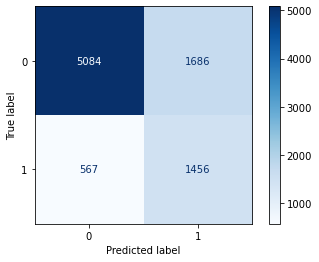

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      6770
           1       0.46      0.72      0.56      2023

    accuracy                           0.74      8793
   macro avg       0.68      0.74      0.69      8793
weighted avg       0.80      0.74      0.76      8793

roc_auc_score:  0.7353416507796966


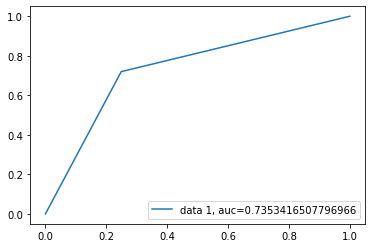

<Figure size 1008x1008 with 0 Axes>

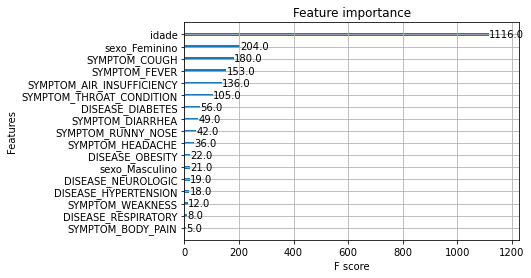

Início do período:  2020-03-27 00:00:00
Final do período:  2020-06-25 00:00:00
########################################

best_score: 0.9360649314904098
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.6001239925604464
########################################
"""Métricas f1_score:"""
f1:  0.5363048166786484
Macro:  0.5924030895382343
Micro:  0.6001239925604464
weighted:  0.6001239925604464
########################################
"""Métricas precision_score:"""
Precision:  0.3903034530868504
Macro:  0.6477379334399769
Micro:  0.6001239925604464
weighted:  0.7662141863323954


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


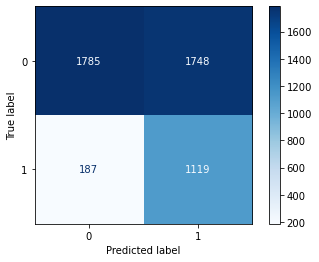

              precision    recall  f1-score   support

           0       0.91      0.51      0.65      3533
           1       0.39      0.86      0.54      1306

    accuracy                           0.60      4839
   macro avg       0.65      0.68      0.59      4839
weighted avg       0.77      0.60      0.62      4839

roc_auc_score:  0.6810255222147427


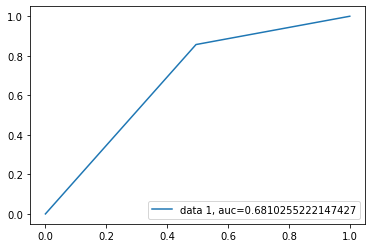

<Figure size 1008x1008 with 0 Axes>

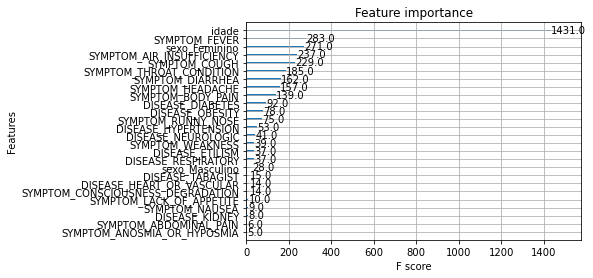

Início do período:  2020-04-26 00:00:00
Final do período:  2020-07-25 00:00:00
########################################

best_score: 0.872081808784246
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5509554140127388
########################################
"""Métricas f1_score:"""
f1:  0.45507246376811594
Macro:  0.5366086760275921
Micro:  0.5509554140127388
weighted:  0.5509554140127388
########################################
"""Métricas precision_score:"""
Precision:  0.3074412532637076
Macro:  0.619536953162466
Micro:  0.5509554140127388
weighted:  0.7979483484867562


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


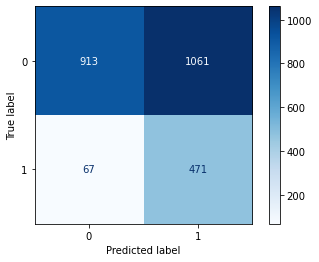

              precision    recall  f1-score   support

           0       0.93      0.46      0.62      1974
           1       0.31      0.88      0.46       538

    accuracy                           0.55      2512
   macro avg       0.62      0.67      0.54      2512
weighted avg       0.80      0.55      0.58      2512

roc_auc_score:  0.668988674327597


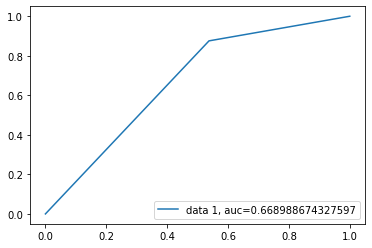

<Figure size 1008x1008 with 0 Axes>

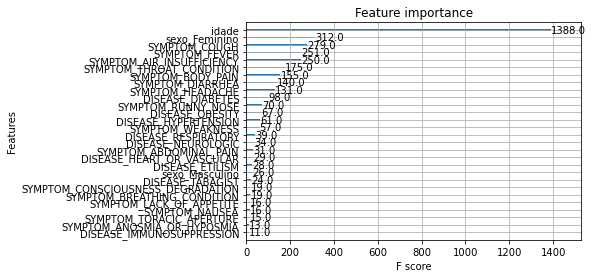

Início do período:  2020-05-26 00:00:00
Final do período:  2020-08-24 00:00:00
########################################

best_score: 0.8707024162343389
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6339746597841389
########################################
"""Métricas f1_score:"""
f1:  0.44365192582025675
Macro:  0.5854623265464919
Micro:  0.6339746597841389
weighted:  0.6339746597841389
########################################
"""Métricas precision_score:"""
Precision:  0.31037924151696605
Macro:  0.6157742088895725
Micro:  0.6339746597841389
weighted:  0.8065206666901069


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


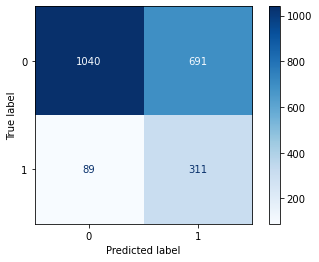

              precision    recall  f1-score   support

           0       0.92      0.60      0.73      1731
           1       0.31      0.78      0.44       400

    accuracy                           0.63      2131
   macro avg       0.62      0.69      0.59      2131
weighted avg       0.81      0.63      0.67      2131

roc_auc_score:  0.6891543905257076


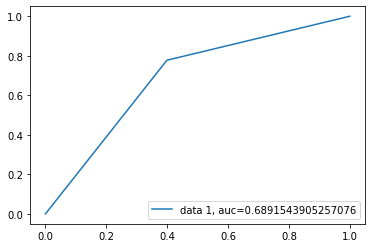

<Figure size 1008x1008 with 0 Axes>

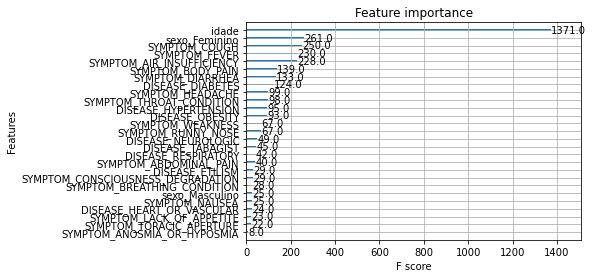

Início do período:  2020-06-25 00:00:00
Final do período:  2020-09-23 00:00:00
########################################

best_score: 0.9222997373935533
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.6751548520302821
########################################
"""Métricas f1_score:"""
f1:  0.42718446601941745
Macro:  0.600239687380506
Micro:  0.6751548520302821
weighted:  0.6751548520302821
########################################
"""Métricas precision_score:"""
Precision:  0.3171171171171171
Macro:  0.6067768213647946
Micro:  0.6751548520302821
weighted:  0.789184687425789


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


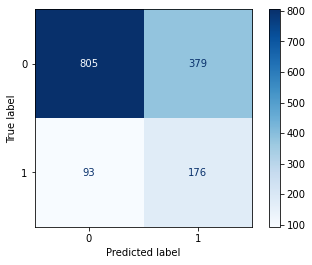

              precision    recall  f1-score   support

           0       0.90      0.68      0.77      1184
           1       0.32      0.65      0.43       269

    accuracy                           0.68      1453
   macro avg       0.61      0.67      0.60      1453
weighted avg       0.79      0.68      0.71      1453

roc_auc_score:  0.6670868707927258


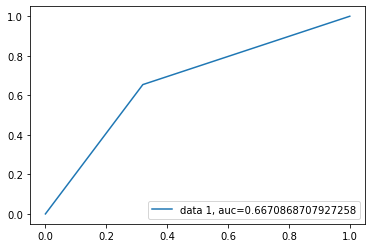

<Figure size 1008x1008 with 0 Axes>

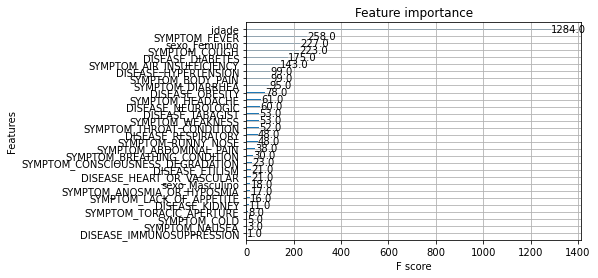

Início do período:  2020-07-25 00:00:00
Final do período:  2020-10-23 00:00:00
########################################

best_score: 0.9363059853259396
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6479289940828402
########################################
"""Métricas f1_score:"""
f1:  0.4447900466562986
Macro:  0.5935141569021565
Micro:  0.6479289940828402
weighted:  0.6479289940828402
########################################
"""Métricas precision_score:"""
Precision:  0.35572139303482586
Macro:  0.5977953370402888
Micro:  0.6479289940828402
weighted:  0.7248006015480859


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


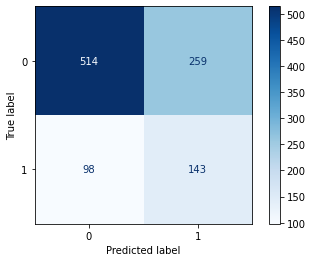

              precision    recall  f1-score   support

           0       0.84      0.66      0.74       773
           1       0.36      0.59      0.44       241

    accuracy                           0.65      1014
   macro avg       0.60      0.63      0.59      1014
weighted avg       0.72      0.65      0.67      1014

roc_auc_score:  0.6291513905514432


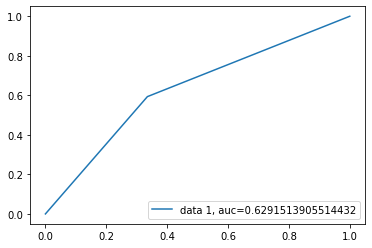

<Figure size 1008x1008 with 0 Axes>

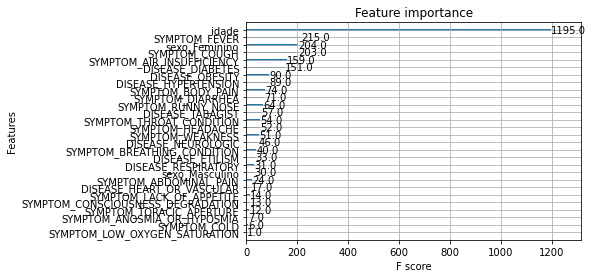

Início do período:  2020-08-24 00:00:00
Final do período:  2020-11-22 00:00:00
########################################

best_score: 0.9319498510027115
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6376146788990825
########################################
"""Métricas f1_score:"""
f1:  0.43490701001430615
Macro:  0.5840976643589424
Micro:  0.6376146788990825
weighted:  0.6376146788990825
########################################
"""Métricas precision_score:"""
Precision:  0.39790575916230364
Macro:  0.5824274558523382
Micro:  0.6376146788990825
weighted:  0.6596218537336738


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


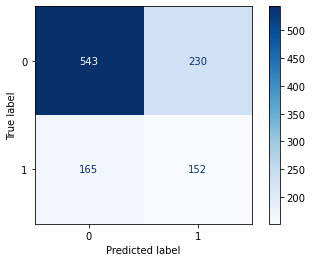

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       773
           1       0.40      0.48      0.43       317

    accuracy                           0.64      1090
   macro avg       0.58      0.59      0.58      1090
weighted avg       0.66      0.64      0.65      1090

roc_auc_score:  0.5909766120771627


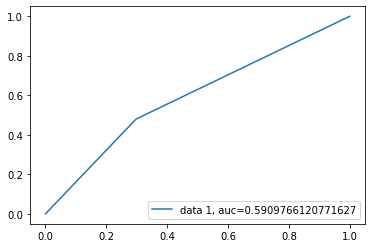

<Figure size 1008x1008 with 0 Axes>

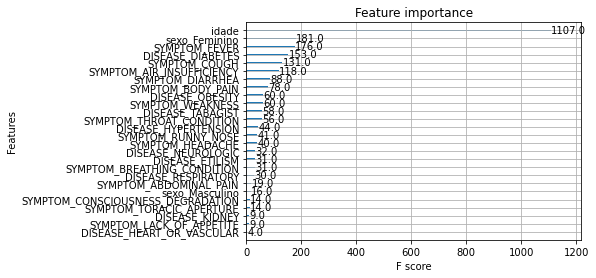

Início do período:  2020-09-23 00:00:00
Final do período:  2020-12-22 00:00:00
########################################

best_score: 0.9058029474392812
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6590038314176245
########################################
"""Métricas f1_score:"""
f1:  0.5340314136125655
Macro:  0.6325746191929897
Micro:  0.6590038314176245
weighted:  0.6590038314176245
########################################
"""Métricas precision_score:"""
Precision:  0.4913294797687861
Macro:  0.6305247907749782
Micro:  0.6590038314176245
weighted:  0.6767099016299064


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


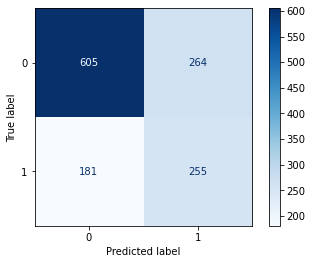

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       869
           1       0.49      0.58      0.53       436

    accuracy                           0.66      1305
   macro avg       0.63      0.64      0.63      1305
weighted avg       0.68      0.66      0.67      1305

roc_auc_score:  0.6405324584833353


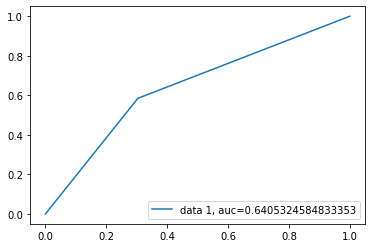

<Figure size 1008x1008 with 0 Axes>

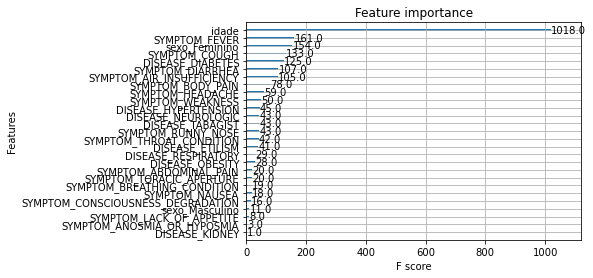

Início do período:  2020-10-23 00:00:00
Final do período:  2021-01-21 00:00:00
########################################

best_score: 0.9024528203786446
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6318306010928961
########################################
"""Métricas f1_score:"""
f1:  0.5578342904019687
Macro:  0.6212225869798025
Micro:  0.6318306010928961
weighted:  0.6318306010928961
########################################
"""Métricas precision_score:"""
Precision:  0.47619047619047616
Macro:  0.628095238095238
Micro:  0.6318306010928961
weighted:  0.6752023158990372


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


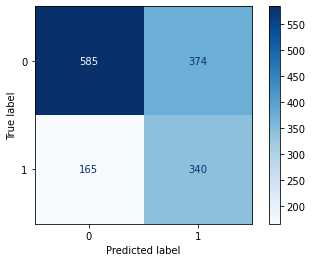

              precision    recall  f1-score   support

           0       0.78      0.61      0.68       959
           1       0.48      0.67      0.56       505

    accuracy                           0.63      1464
   macro avg       0.63      0.64      0.62      1464
weighted avg       0.68      0.63      0.64      1464

roc_auc_score:  0.6416388771306746


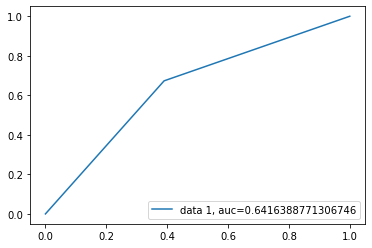

<Figure size 1008x1008 with 0 Axes>

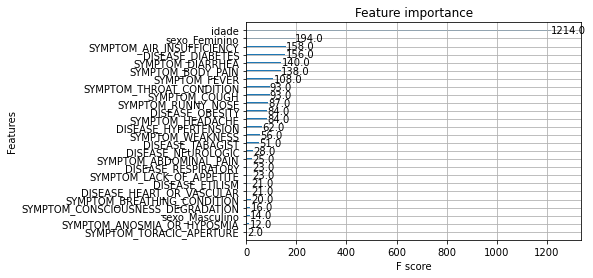

Início do período:  2020-11-22 00:00:00
Final do período:  2021-02-20 00:00:00
########################################

best_score: 0.8567422403010333
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.6464857341684064
########################################
"""Métricas f1_score:"""
f1:  0.568760611205433
Macro:  0.6346161546593203
Micro:  0.6464857341684064
weighted:  0.6464857341684064
########################################
"""Métricas precision_score:"""
Precision:  0.4841040462427746
Macro:  0.6407097412421927
Micro:  0.6464857341684064
weighted:  0.6913859055948227


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


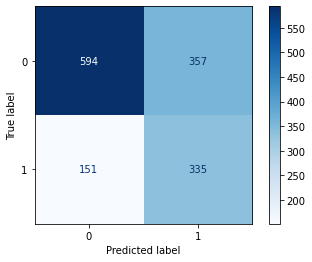

              precision    recall  f1-score   support

           0       0.80      0.62      0.70       951
           1       0.48      0.69      0.57       486

    accuracy                           0.65      1437
   macro avg       0.64      0.66      0.63      1437
weighted avg       0.69      0.65      0.66      1437

roc_auc_score:  0.6569530448780361


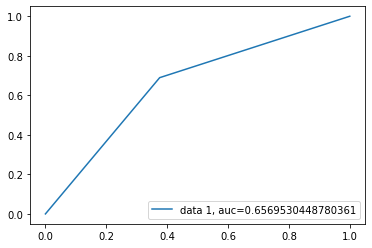

<Figure size 1008x1008 with 0 Axes>

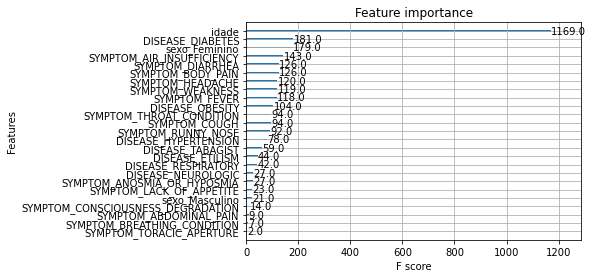

Início do período:  2020-12-22 00:00:00
Final do período:  2021-03-22 00:00:00
########################################

best_score: 0.8436974103056041
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6446850393700787
########################################
"""Métricas f1_score:"""
f1:  0.5565110565110565
Macro:  0.6300617679928024
Micro:  0.6446850393700787
weighted:  0.6446850393700787
########################################
"""Métricas precision_score:"""
Precision:  0.4670103092783505
Macro:  0.6369891471062186
Micro:  0.6446850393700787
weighted:  0.696883265159739


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


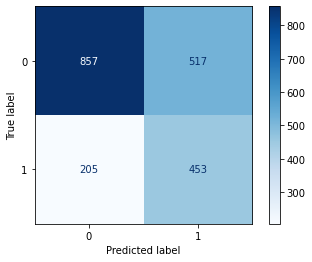

              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1374
           1       0.47      0.69      0.56       658

    accuracy                           0.64      2032
   macro avg       0.64      0.66      0.63      2032
weighted avg       0.70      0.64      0.66      2032

roc_auc_score:  0.656088097229043


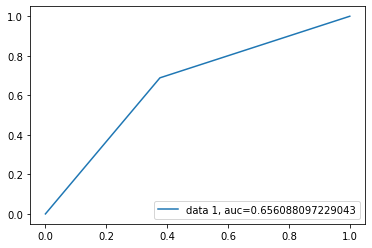

<Figure size 1008x1008 with 0 Axes>

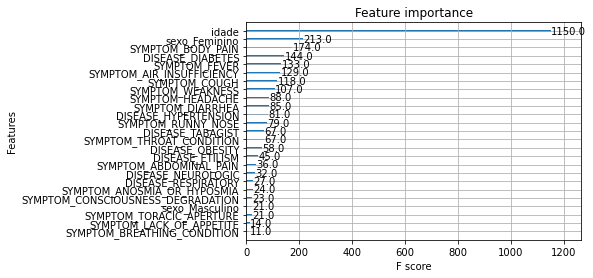

Início do período:  2021-01-21 00:00:00
Final do período:  2021-04-21 00:00:00
########################################

best_score: 0.8551565602317481
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6498133695283339
########################################
"""Métricas f1_score:"""
f1:  0.546174142480211
Macro:  0.6305456347760171
Micro:  0.6498133695283339
weighted:  0.6498133695283339
########################################
"""Métricas precision_score:"""
Precision:  0.47116843702579664
Macro:  0.6327604002194668
Micro:  0.6498133695283339
weighted:  0.6895122434177866


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


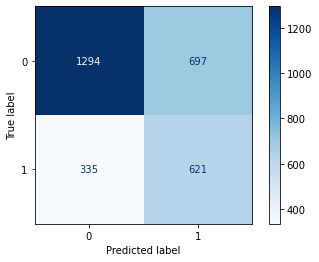

              precision    recall  f1-score   support

           0       0.79      0.65      0.71      1991
           1       0.47      0.65      0.55       956

    accuracy                           0.65      2947
   macro avg       0.63      0.65      0.63      2947
weighted avg       0.69      0.65      0.66      2947

roc_auc_score:  0.6497531254662718


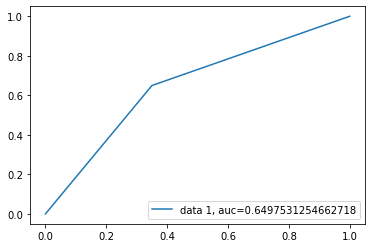

<Figure size 1008x1008 with 0 Axes>

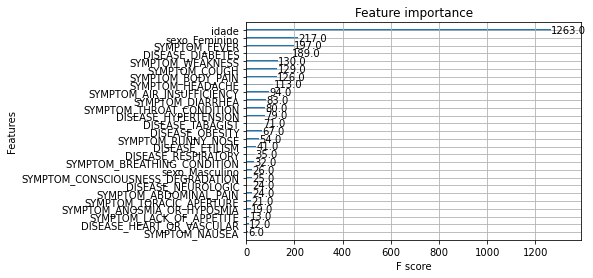

Início do período:  2021-02-20 00:00:00
Final do período:  2021-05-21 00:00:00
########################################

best_score: 0.8536384673813618
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.58968850698174
########################################
"""Métricas f1_score:"""
f1:  0.5408653846153846
Macro:  0.5849957991038088
Micro:  0.58968850698174
weighted:  0.58968850698174
########################################
"""Métricas precision_score:"""
Precision:  0.4202988792029888
Macro:  0.6195849914127833
Micro:  0.58968850698174
weighted:  0.6918645587842557


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


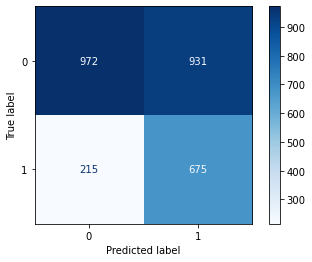

              precision    recall  f1-score   support

           0       0.82      0.51      0.63      1903
           1       0.42      0.76      0.54       890

    accuracy                           0.59      2793
   macro avg       0.62      0.63      0.58      2793
weighted avg       0.69      0.59      0.60      2793

roc_auc_score:  0.6345997154109124


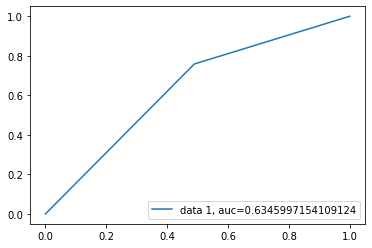

<Figure size 1008x1008 with 0 Axes>

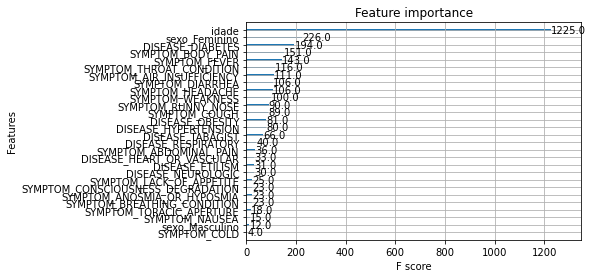

Início do período:  2021-03-22 00:00:00
Final do período:  2021-06-20 00:00:00
########################################

best_score: 0.8493245827821745
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5550959007145544
########################################
"""Métricas f1_score:"""
f1:  0.5006331785563529
Macro:  0.5497401226793295
Micro:  0.5550959007145544
weighted:  0.5550959007145544
########################################
"""Métricas precision_score:"""
Precision:  0.3697007481296758
Macro:  0.6033337863871128
Micro:  0.5550959007145544
weighted:  0.7025333727702066


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


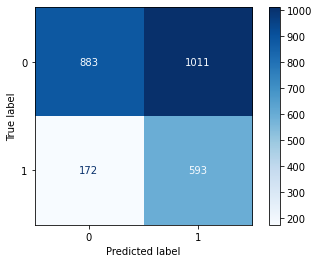

              precision    recall  f1-score   support

           0       0.84      0.47      0.60      1894
           1       0.37      0.78      0.50       765

    accuracy                           0.56      2659
   macro avg       0.60      0.62      0.55      2659
weighted avg       0.70      0.56      0.57      2659

roc_auc_score:  0.6206862400011042


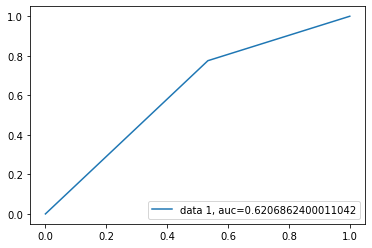

<Figure size 1008x1008 with 0 Axes>

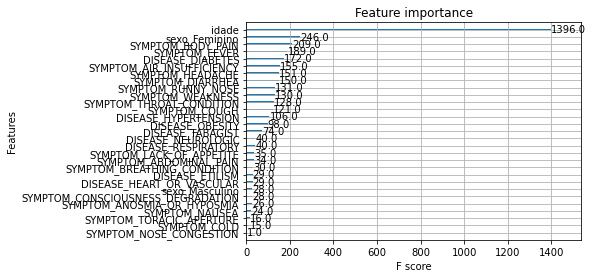

Início do período:  2021-04-21 00:00:00
Final do período:  2021-07-20 00:00:00
########################################

best_score: 0.8749524811210823
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5733610822060354
########################################
"""Métricas f1_score:"""
f1:  0.49816401468788246
Macro:  0.563561645352991
Micro:  0.5733610822060354
weighted:  0.5733610822060354
########################################
"""Métricas precision_score:"""
Precision:  0.37546125461254615
Macro:  0.6024084316022158
Micro:  0.5733610822060354
weighted:  0.699469086901648


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


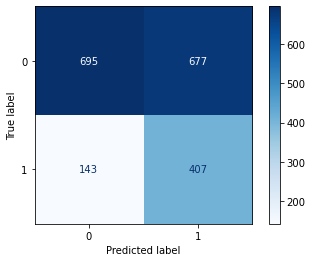

              precision    recall  f1-score   support

           0       0.83      0.51      0.63      1372
           1       0.38      0.74      0.50       550

    accuracy                           0.57      1922
   macro avg       0.60      0.62      0.56      1922
weighted avg       0.70      0.57      0.59      1922

roc_auc_score:  0.6232798833819242


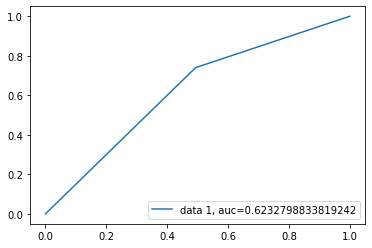

<Figure size 1008x1008 with 0 Axes>

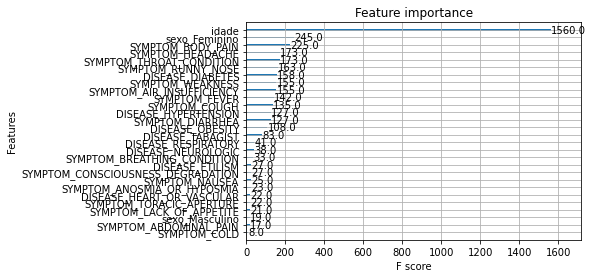

Início do período:  2021-05-21 00:00:00
Final do período:  2021-08-19 00:00:00
########################################

best_score: 0.8828691184424013
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6029929577464789
########################################
"""Métricas f1_score:"""
f1:  0.560856864654333
Macro:  0.5993039343351987
Micro:  0.6029929577464789
weighted:  0.6029929577464789
########################################
"""Métricas precision_score:"""
Precision:  0.45
Macro:  0.6252016129032258
Micro:  0.6029929577464789
weighted:  0.6810317043389369


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


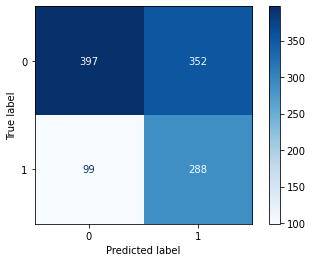

              precision    recall  f1-score   support

           0       0.80      0.53      0.64       749
           1       0.45      0.74      0.56       387

    accuracy                           0.60      1136
   macro avg       0.63      0.64      0.60      1136
weighted avg       0.68      0.60      0.61      1136

roc_auc_score:  0.6371130499580836


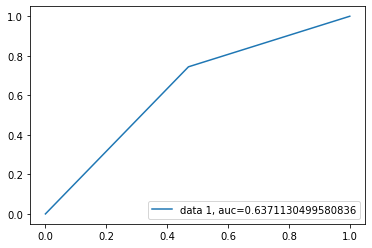

<Figure size 1008x1008 with 0 Axes>

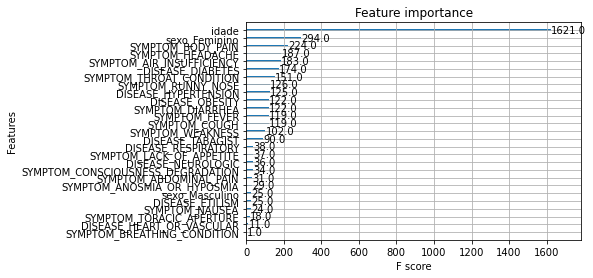

Início do período:  2021-06-20 00:00:00
Final do período:  2021-09-18 00:00:00
########################################

best_score: 0.8830554416609496
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5945273631840796
########################################
"""Métricas f1_score:"""
f1:  0.5134328358208955
Macro:  0.5829424307036247
Micro:  0.5945273631840796
weighted:  0.5945273631840796
########################################
"""Métricas precision_score:"""
Precision:  0.40186915887850466
Macro:  0.6078494730562736
Micro:  0.5945273631840796
weighted:  0.6898316876543906


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


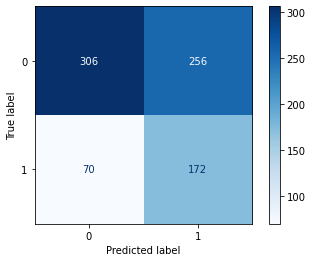

              precision    recall  f1-score   support

           0       0.81      0.54      0.65       562
           1       0.40      0.71      0.51       242

    accuracy                           0.59       804
   macro avg       0.61      0.63      0.58       804
weighted avg       0.69      0.59      0.61       804

roc_auc_score:  0.6276138937090086


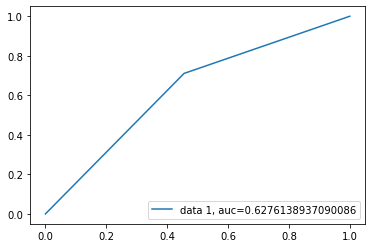

<Figure size 1008x1008 with 0 Axes>

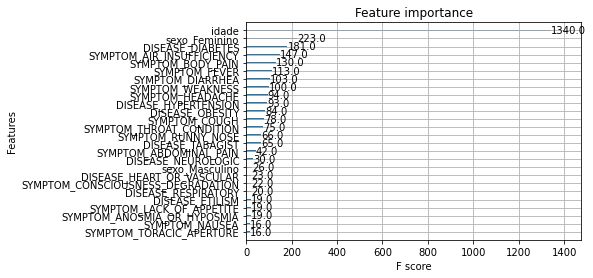

Início do período:  2021-07-20 00:00:00
Final do período:  2021-10-18 00:00:00
########################################

best_score: 0.8942909248496722
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5748031496062992
########################################
"""Métricas f1_score:"""
f1:  0.49193548387096775
Macro:  0.5631824421289076
Micro:  0.5748031496062992
weighted:  0.5748031496062992
########################################
"""Métricas precision_score:"""
Precision:  0.3588235294117647
Macro:  0.6121294428061462
Micro:  0.5748031496062992
weighted:  0.7320864614102347


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


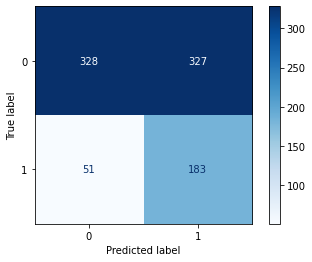

              precision    recall  f1-score   support

           0       0.87      0.50      0.63       655
           1       0.36      0.78      0.49       234

    accuracy                           0.57       889
   macro avg       0.61      0.64      0.56       889
weighted avg       0.73      0.57      0.60       889

roc_auc_score:  0.641407320414954


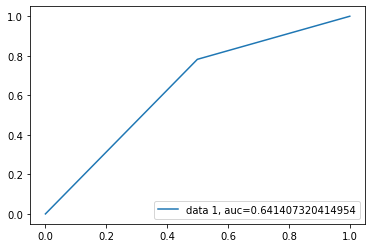

<Figure size 1008x1008 with 0 Axes>

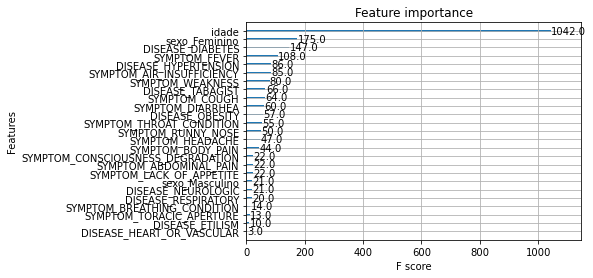

Início do período:  2021-08-19 00:00:00
Final do período:  2021-11-17 00:00:00
########################################

best_score: 0.90443115234375
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5981055480378891
########################################
"""Métricas f1_score:"""
f1:  0.3850931677018634
Macro:  0.5433003526951528
Micro:  0.5981055480378891
weighted:  0.5981055480378891
########################################
"""Métricas precision_score:"""
Precision:  0.29153605015673983
Macro:  0.5612442155545604
Micro:  0.5981055480378891
weighted:  0.7112442913035514


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


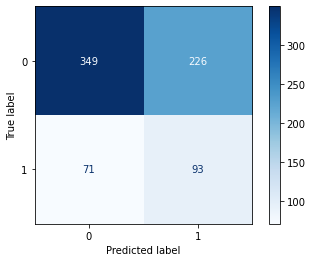

              precision    recall  f1-score   support

           0       0.83      0.61      0.70       575
           1       0.29      0.57      0.39       164

    accuracy                           0.60       739
   macro avg       0.56      0.59      0.54       739
weighted avg       0.71      0.60      0.63       739

roc_auc_score:  0.5870148462354188


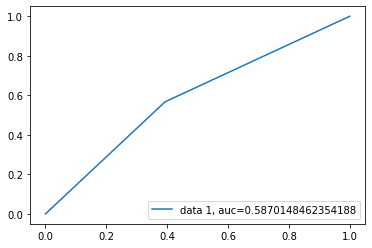

<Figure size 1008x1008 with 0 Axes>

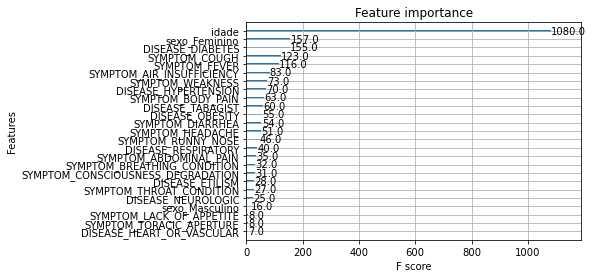

Início do período:  2021-09-18 00:00:00
Final do período:  2021-12-17 00:00:00
########################################

best_score: 0.9057838631255446
best_params_: {'colsample_bytree': 0.9, 'gamma': 1, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6046511627906976
########################################
"""Métricas f1_score:"""
f1:  0.35920177383592017
Macro:  0.5366730926548543
Micro:  0.6046511627906976
weighted:  0.6046511627906976
########################################
"""Métricas precision_score:"""
Precision:  0.2755102040816326
Macro:  0.5507985803016859
Micro:  0.6046511627906976
weighted:  0.7078372299374756


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


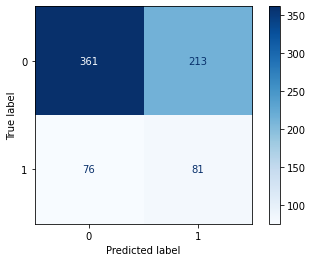

              precision    recall  f1-score   support

           0       0.83      0.63      0.71       574
           1       0.28      0.52      0.36       157

    accuracy                           0.60       731
   macro avg       0.55      0.57      0.54       731
weighted avg       0.71      0.60      0.64       731

roc_auc_score:  0.5724217137530794


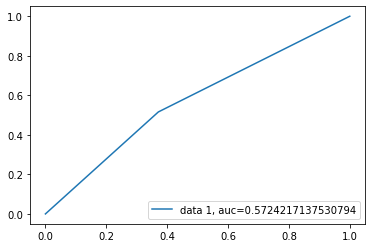

<Figure size 1008x1008 with 0 Axes>

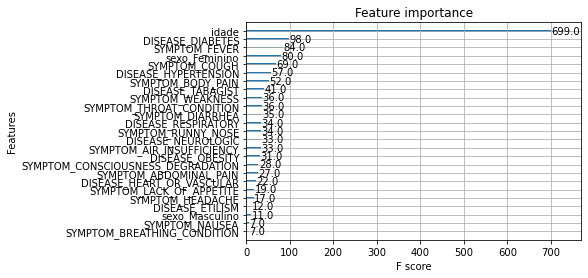

Início do período:  2021-10-18 00:00:00
Final do período:  2022-01-16 00:00:00
########################################

best_score: 0.9366748699271591
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6147157190635452
########################################
"""Métricas f1_score:"""
f1:  0.3317865429234339
Macro:  0.5305549255970553
Micro:  0.6147157190635452
weighted:  0.6147157190635452
########################################
"""Métricas precision_score:"""
Precision:  0.2771317829457364
Macro:  0.5348886698181184
Micro:  0.6147157190635452
weighted:  0.6733360144057592


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


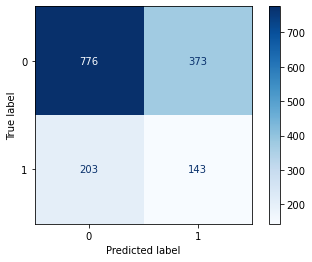

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1149
           1       0.28      0.41      0.33       346

    accuracy                           0.61      1495
   macro avg       0.53      0.54      0.53      1495
weighted avg       0.67      0.61      0.64      1495

roc_auc_score:  0.5443323422729993


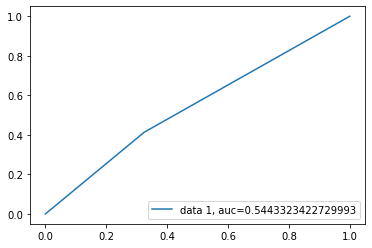

<Figure size 1008x1008 with 0 Axes>

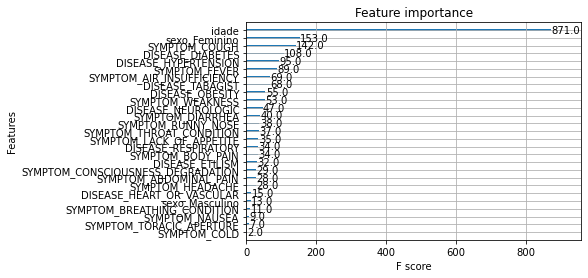

Início do período:  2021-11-17 00:00:00
Final do período:  2022-02-15 00:00:00
########################################

best_score: 0.9028681301073547
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5784148397976391
########################################
"""Métricas f1_score:"""
f1:  0.37913907284768206
Macro:  0.5299950683387347
Micro:  0.5784148397976391
weighted:  0.5784148397976391
########################################
"""Métricas precision_score:"""
Precision:  0.296248382923674
Macro:  0.5457385055771452
Micro:  0.5784148397976391
weighted:  0.6732182815704029


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


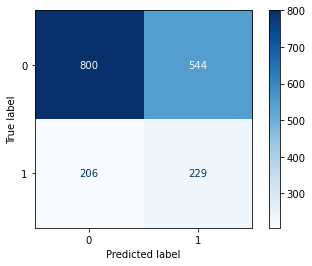

              precision    recall  f1-score   support

           0       0.80      0.60      0.68      1344
           1       0.30      0.53      0.38       435

    accuracy                           0.58      1779
   macro avg       0.55      0.56      0.53      1779
weighted avg       0.67      0.58      0.61      1779

roc_auc_score:  0.5608374384236453


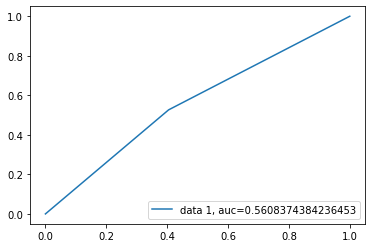

<Figure size 1008x1008 with 0 Axes>

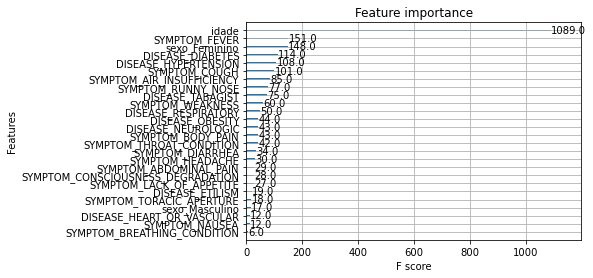

Início do período:  2021-12-17 00:00:00
Final do período:  2022-03-17 00:00:00
########################################

best_score: 0.8766862912248922
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5140913508260447
########################################
"""Métricas f1_score:"""
f1:  0.4356659142212189
Macro:  0.5045223769058313
Micro:  0.5140913508260447
weighted:  0.5140913508260447
########################################
"""Métricas precision_score:"""
Precision:  0.3403880070546737
Macro:  0.5338303671637005
Micro:  0.5140913508260447
weighted:  0.6073347041924949


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


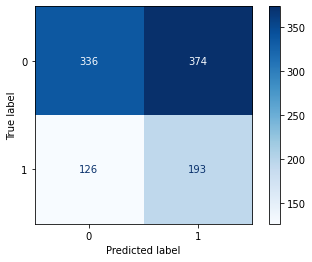

              precision    recall  f1-score   support

           0       0.73      0.47      0.57       710
           1       0.34      0.61      0.44       319

    accuracy                           0.51      1029
   macro avg       0.53      0.54      0.50      1029
weighted avg       0.61      0.51      0.53      1029

roc_auc_score:  0.5391275553004548


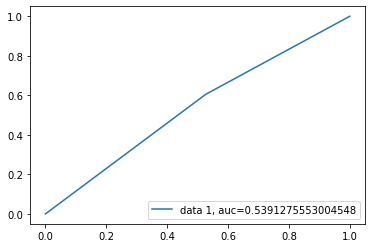

<Figure size 1008x1008 with 0 Axes>

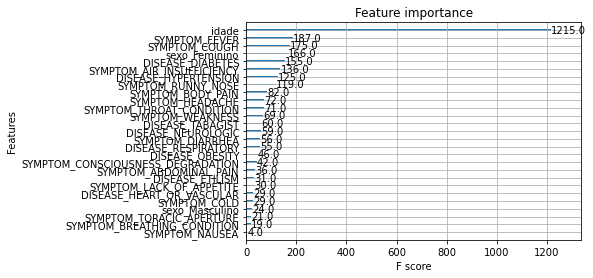

Início do período:  2022-01-16 00:00:00
Final do período:  2022-04-16 00:00:00
########################################

best_score: 0.8692303068075834
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.618925831202046
########################################
"""Métricas f1_score:"""
f1:  0.5484848484848485
Macro:  0.6094194153928667
Micro:  0.618925831202046
weighted:  0.618925831202046
########################################
"""Métricas precision_score:"""
Precision:  0.49318801089918257
Macro:  0.6116542464134467
Micro:  0.618925831202046
weighted:  0.641346550966894


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


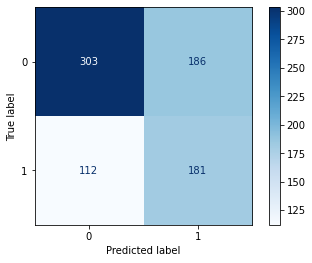

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       489
           1       0.49      0.62      0.55       293

    accuracy                           0.62       782
   macro avg       0.61      0.62      0.61       782
weighted avg       0.64      0.62      0.62       782

roc_auc_score:  0.6186896710567642


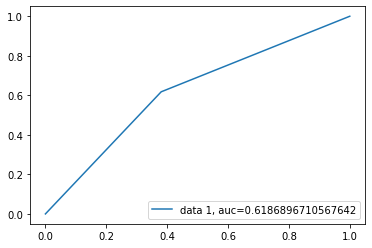

<Figure size 1008x1008 with 0 Axes>

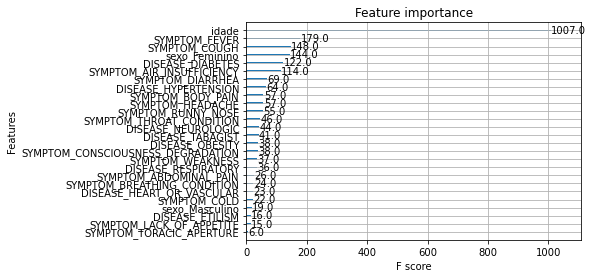

Início do período:  2022-02-15 00:00:00
Final do período:  2022-05-16 00:00:00
########################################

best_score: 0.8128762660817863
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.6737804878048781
########################################
"""Métricas f1_score:"""
f1:  0.5387931034482759
Macro:  0.6432173064411191
Micro:  0.6737804878048781
weighted:  0.6737804878048781
########################################
"""Métricas precision_score:"""
Precision:  0.4528985507246377
Macro:  0.6435545385202136
Micro:  0.6737804878048781
weighted:  0.7249320942866179


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


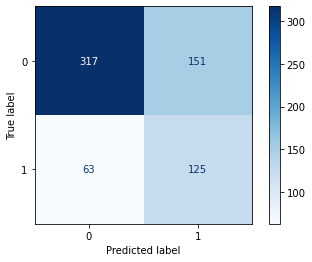

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       468
           1       0.45      0.66      0.54       188

    accuracy                           0.67       656
   macro avg       0.64      0.67      0.64       656
weighted avg       0.72      0.67      0.69       656

roc_auc_score:  0.6711220221858519


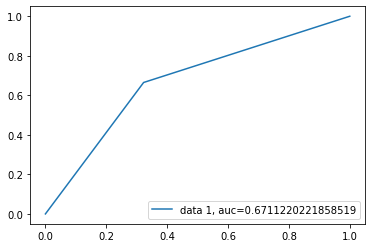

<Figure size 1008x1008 with 0 Axes>

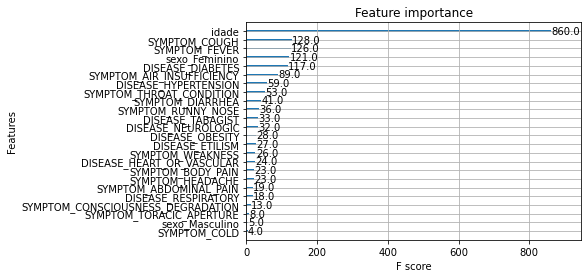

Início do período:  2022-03-17 00:00:00
Final do período:  2022-06-15 00:00:00
########################################

best_score: 0.8548387385452463
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.7347266881028939
########################################
"""Métricas f1_score:"""
f1:  0.3373493975903614
Macro:  0.5857601259308591
Micro:  0.7347266881028939
weighted:  0.7347266881028939
########################################
"""Métricas precision_score:"""
Precision:  0.22459893048128343
Macro:  0.5893109594935153
Micro:  0.7347266881028939
weighted:  0.8813151242010577


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


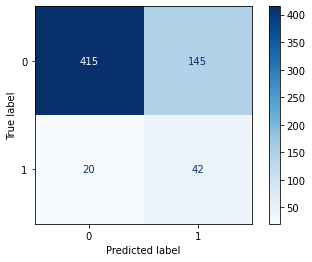

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       560
           1       0.22      0.68      0.34        62

    accuracy                           0.73       622
   macro avg       0.59      0.71      0.59       622
weighted avg       0.88      0.73      0.78       622

roc_auc_score:  0.7092453917050692


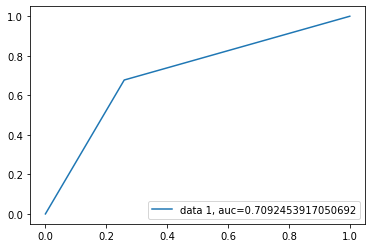

<Figure size 1008x1008 with 0 Axes>

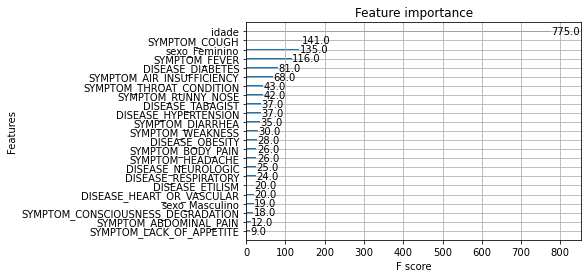

In [9]:
result_f1_90, result_precision_90 = apply_periodos(90, df)

Início do período:  2020-02-26 00:00:00
Final do período:  2020-06-25 00:00:00
########################################

best_score: 0.9591698013508185
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.6808510638297872
########################################
"""Métricas f1_score:"""
f1:  0.574468085106383
Macro:  0.6595744680851063
Micro:  0.6808510638297872
weighted:  0.6808510638297872
########################################
"""Métricas precision_score:"""
Precision:  0.44354628422425035
Macro:  0.6742479020234771
Micro:  0.6808510638297872
weighted:  0.7829955491167803


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


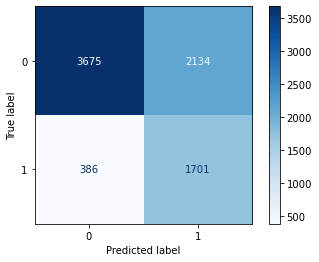

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      5809
           1       0.44      0.82      0.57      2087

    accuracy                           0.68      7896
   macro avg       0.67      0.72      0.66      7896
weighted avg       0.78      0.68      0.70      7896

roc_auc_score:  0.7238422641600946


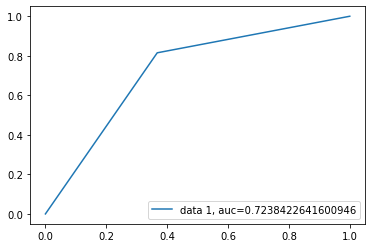

<Figure size 1008x1008 with 0 Axes>

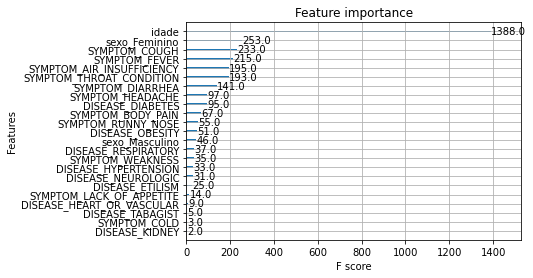

Início do período:  2020-03-27 00:00:00
Final do período:  2020-07-25 00:00:00
########################################

best_score: 0.9106211188322453
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.5652734778121775
########################################
"""Métricas f1_score:"""
f1:  0.4910903050437934
Macro:  0.5558356276401133
Micro:  0.5652734778121775
weighted:  0.5652734778121775
########################################
"""Métricas precision_score:"""
Precision:  0.33917396745932415
Macro:  0.6354422913699596
Micro:  0.5652734778121775
weighted:  0.7919844810936388


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


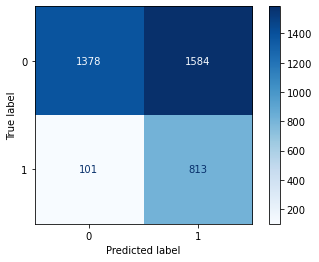

              precision    recall  f1-score   support

           0       0.93      0.47      0.62      2962
           1       0.34      0.89      0.49       914

    accuracy                           0.57      3876
   macro avg       0.64      0.68      0.56      3876
weighted avg       0.79      0.57      0.59      3876

roc_auc_score:  0.677361458119403


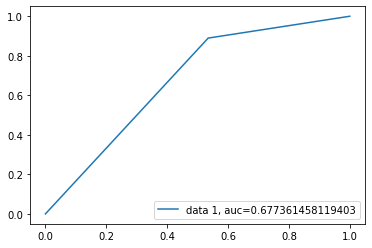

<Figure size 1008x1008 with 0 Axes>

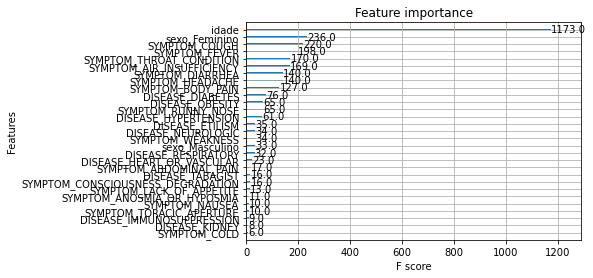

Início do período:  2020-04-26 00:00:00
Final do período:  2020-08-24 00:00:00
########################################

best_score: 0.8539120170336154
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5816678152997933
########################################
"""Métricas f1_score:"""
f1:  0.4506787330316741
Macro:  0.5564467677400997
Micro:  0.5816678152997933
weighted:  0.5816678152997933
########################################
"""Métricas precision_score:"""
Precision:  0.3025516403402187
Macro:  0.6250019348197908
Micro:  0.5816678152997933
weighted:  0.822116622072293


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


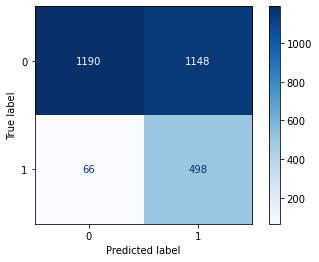

              precision    recall  f1-score   support

           0       0.95      0.51      0.66      2338
           1       0.30      0.88      0.45       564

    accuracy                           0.58      2902
   macro avg       0.63      0.70      0.56      2902
weighted avg       0.82      0.58      0.62      2902

roc_auc_score:  0.6959803796661994


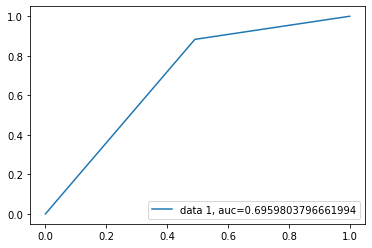

<Figure size 1008x1008 with 0 Axes>

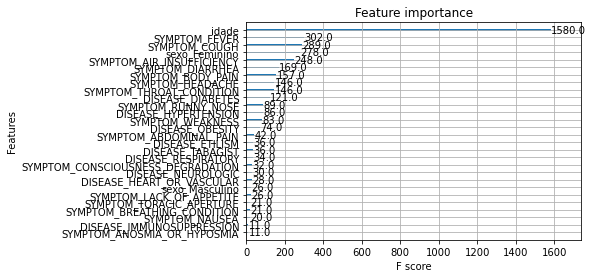

Início do período:  2020-05-26 00:00:00
Final do período:  2020-09-23 00:00:00
########################################

best_score: 0.8647814193783312
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6189365671641791
########################################
"""Métricas f1_score:"""
f1:  0.45130960376091334
Macro:  0.5797098215303316
Micro:  0.6189365671641791
weighted:  0.6189365671641791
########################################
"""Métricas precision_score:"""
Precision:  0.30996309963099633
Macro:  0.6224343800041774
Micro:  0.6189365671641791
weighted:  0.816854477027416


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


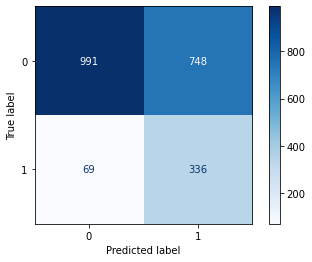

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      1739
           1       0.31      0.83      0.45       405

    accuracy                           0.62      2144
   macro avg       0.62      0.70      0.58      2144
weighted avg       0.82      0.62      0.66      2144

roc_auc_score:  0.6997486848550679


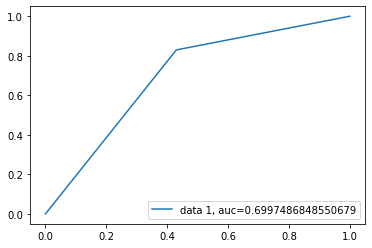

<Figure size 1008x1008 with 0 Axes>

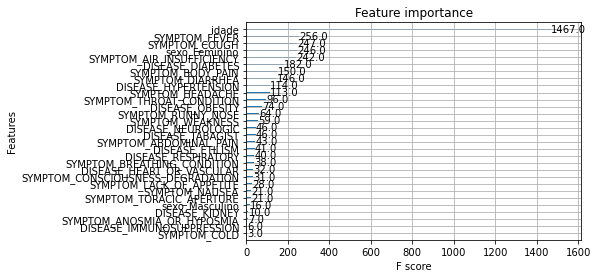

Início do período:  2020-06-25 00:00:00
Final do período:  2020-10-23 00:00:00
########################################

best_score: 0.9221255273686918
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6131191432396251
########################################
"""Métricas f1_score:"""
f1:  0.45161290322580644
Macro:  0.5763752210027687
Micro:  0.6131191432396251
weighted:  0.6131191432396251
########################################
"""Métricas precision_score:"""
Precision:  0.33055555555555555
Macro:  0.6032622739018088
Micro:  0.6131191432396251
weighted:  0.754035867846926


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


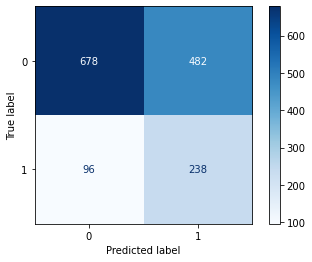

              precision    recall  f1-score   support

           0       0.88      0.58      0.70      1160
           1       0.33      0.71      0.45       334

    accuracy                           0.61      1494
   macro avg       0.60      0.65      0.58      1494
weighted avg       0.75      0.61      0.65      1494

roc_auc_score:  0.6485288044600455


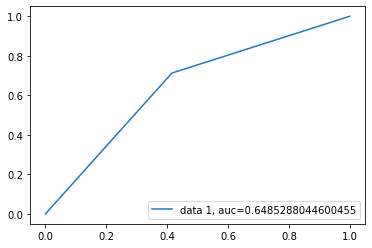

<Figure size 1008x1008 with 0 Axes>

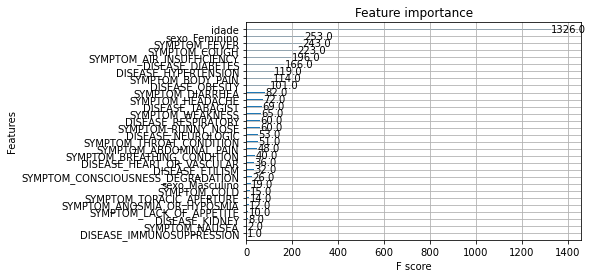

Início do período:  2020-07-25 00:00:00
Final do período:  2020-11-22 00:00:00
########################################

best_score: 0.9370254390495866
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6343859649122807
########################################
"""Métricas f1_score:"""
f1:  0.46122026887280254
Macro:  0.592267064866566
Micro:  0.6343859649122807
weighted:  0.6343859649122807
########################################
"""Métricas precision_score:"""
Precision:  0.3932980599647266
Macro:  0.5935021768355102
Micro:  0.6343859649122807
weighted:  0.6813110000244503


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


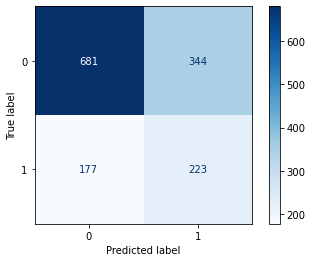

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1025
           1       0.39      0.56      0.46       400

    accuracy                           0.63      1425
   macro avg       0.59      0.61      0.59      1425
weighted avg       0.68      0.63      0.65      1425

roc_auc_score:  0.6109451219512195


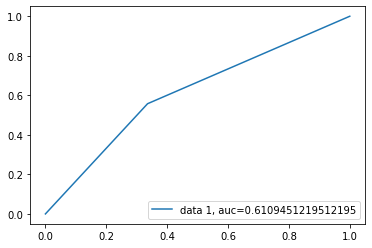

<Figure size 1008x1008 with 0 Axes>

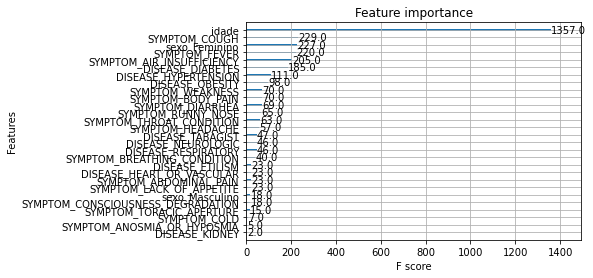

Início do período:  2020-08-24 00:00:00
Final do período:  2020-12-22 00:00:00
########################################

best_score: 0.9212078949226751
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6433973240255962
########################################
"""Métricas f1_score:"""
f1:  0.49044056525353286
Macro:  0.6080838173023817
Micro:  0.6433973240255962
weighted:  0.6433973240255962
########################################
"""Métricas precision_score:"""
Precision:  0.4573643410852713
Macro:  0.6062426919579057
Micro:  0.6433973240255962
weighted:  0.65846703493417


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


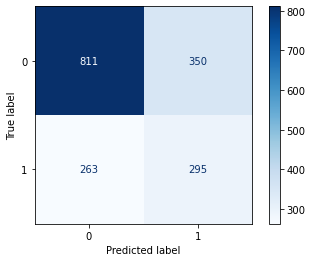

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1161
           1       0.46      0.53      0.49       558

    accuracy                           0.64      1719
   macro avg       0.61      0.61      0.61      1719
weighted avg       0.66      0.64      0.65      1719

roc_auc_score:  0.6136047900864106


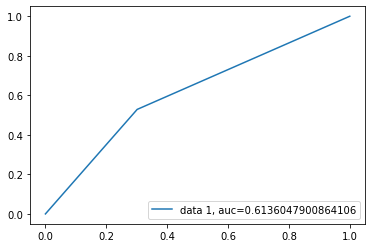

<Figure size 1008x1008 with 0 Axes>

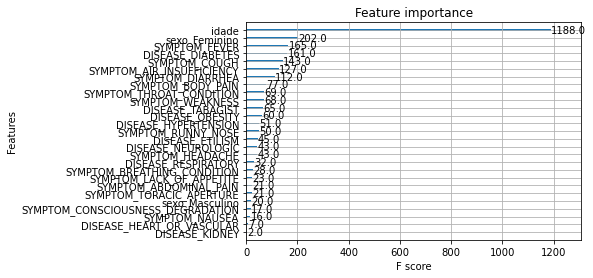

Início do período:  2020-09-23 00:00:00
Final do período:  2021-01-21 00:00:00
########################################

best_score: 0.8928421161127927
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6339001062699257
########################################
"""Métricas f1_score:"""
f1:  0.5546218487394958
Macro:  0.6219207574775512
Micro:  0.6339001062699257
weighted:  0.6339001062699257
########################################
"""Métricas precision_score:"""
Precision:  0.477728285077951
Macro:  0.6270755246527966
Micro:  0.6339001062699257
weighted:  0.6734191951691143


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


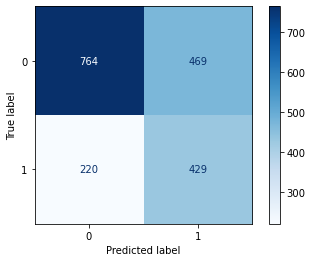

              precision    recall  f1-score   support

           0       0.78      0.62      0.69      1233
           1       0.48      0.66      0.55       649

    accuracy                           0.63      1882
   macro avg       0.63      0.64      0.62      1882
weighted avg       0.67      0.63      0.64      1882

roc_auc_score:  0.6403219376744058


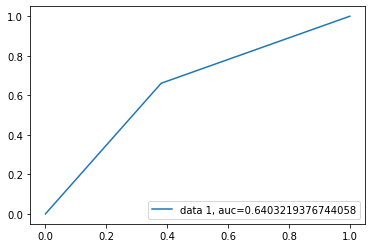

<Figure size 1008x1008 with 0 Axes>

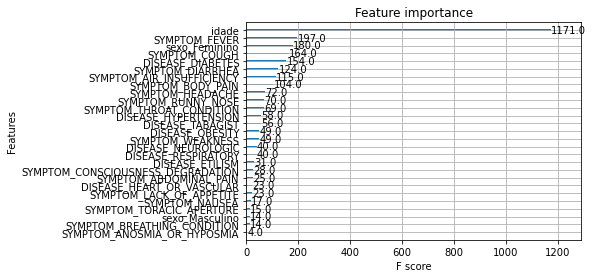

Início do período:  2020-10-23 00:00:00
Final do período:  2021-02-20 00:00:00
########################################

best_score: 0.8907795422286384
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6294524189261032
########################################
"""Métricas f1_score:"""
f1:  0.5726548129981607
Macro:  0.6227891615436603
Micro:  0.6294524189261032
weighted:  0.6294524189261032
########################################
"""Métricas precision_score:"""
Precision:  0.4637537239324727
Macro:  0.6420599283277924
Micro:  0.6294524189261032
weighted:  0.7020640896155316


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


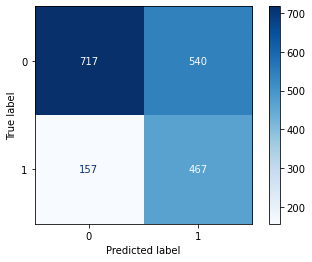

              precision    recall  f1-score   support

           0       0.82      0.57      0.67      1257
           1       0.46      0.75      0.57       624

    accuracy                           0.63      1881
   macro avg       0.64      0.66      0.62      1881
weighted avg       0.70      0.63      0.64      1881

roc_auc_score:  0.6594015819105318


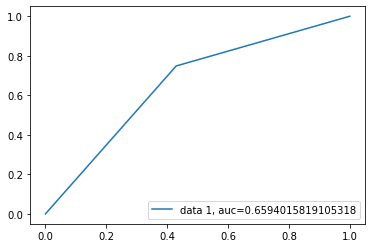

<Figure size 1008x1008 with 0 Axes>

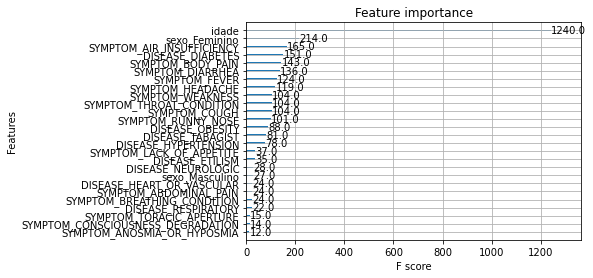

Início do período:  2020-11-22 00:00:00
Final do período:  2021-03-22 00:00:00
########################################

best_score: 0.8598087127626973
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6501002004008016
########################################
"""Métricas f1_score:"""
f1:  0.5768298594280173
Macro:  0.6392861288940566
Micro:  0.6501002004008016
weighted:  0.6501002004008016
########################################
"""Métricas precision_score:"""
Precision:  0.476
Macro:  0.6504497991967871
Micro:  0.6501002004008016
weighted:  0.711210069939075


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


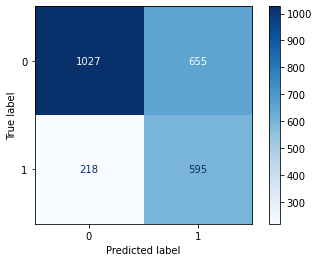

              precision    recall  f1-score   support

           0       0.82      0.61      0.70      1682
           1       0.48      0.73      0.58       813

    accuracy                           0.65      2495
   macro avg       0.65      0.67      0.64      2495
weighted avg       0.71      0.65      0.66      2495

roc_auc_score:  0.6712199791439055


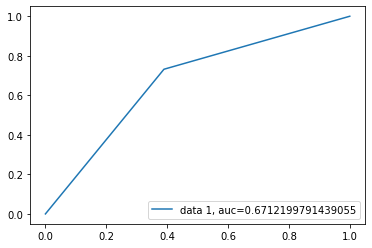

<Figure size 1008x1008 with 0 Axes>

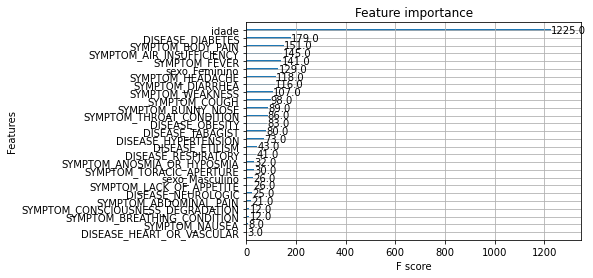

Início do período:  2020-12-22 00:00:00
Final do período:  2021-04-21 00:00:00
########################################

best_score: 0.8498263996527994
best_params_: {'colsample_bytree': 0.5, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6281435433738344
########################################
"""Métricas f1_score:"""
f1:  0.5662491760052736
Macro:  0.6204144000698969
Micro:  0.6281435433738344
weighted:  0.6281435433738344
########################################
"""Métricas precision_score:"""
Precision:  0.45935828877005347
Macro:  0.6383070652957517
Micro:  0.6281435433738344
weighted:  0.6995410207556614


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


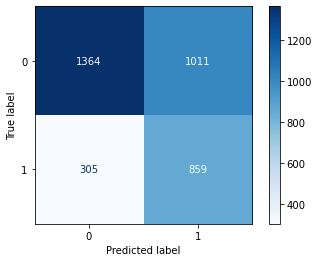

              precision    recall  f1-score   support

           0       0.82      0.57      0.67      2375
           1       0.46      0.74      0.57      1164

    accuracy                           0.63      3539
   macro avg       0.64      0.66      0.62      3539
weighted avg       0.70      0.63      0.64      3539

roc_auc_score:  0.6561441490323747


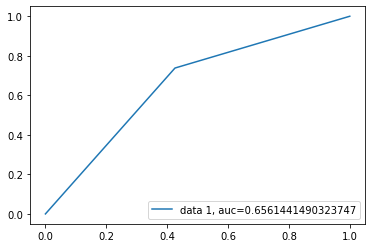

<Figure size 1008x1008 with 0 Axes>

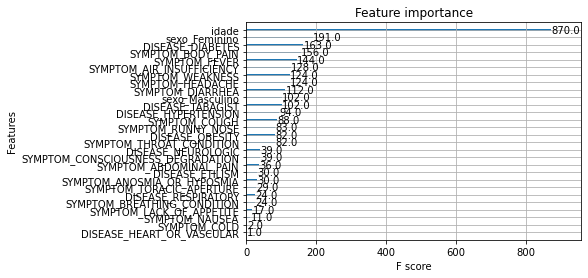

Início do período:  2021-01-21 00:00:00
Final do período:  2021-05-21 00:00:00
########################################

best_score: 0.8572075840364345
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.64629388816645
########################################
"""Métricas f1_score:"""
f1:  0.5514511873350924
Macro:  0.6297401922076922
Micro:  0.64629388816645
weighted:  0.64629388816645
########################################
"""Métricas precision_score:"""
Precision:  0.47125140924464487
Macro:  0.6337425563847561
Micro:  0.64629388816645
weighted:  0.6899065965796085


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


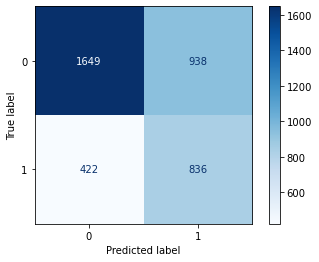

              precision    recall  f1-score   support

           0       0.80      0.64      0.71      2587
           1       0.47      0.66      0.55      1258

    accuracy                           0.65      3845
   macro avg       0.63      0.65      0.63      3845
weighted avg       0.69      0.65      0.66      3845

roc_auc_score:  0.6509823791822018


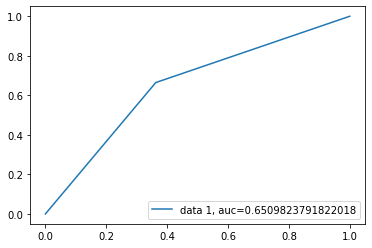

<Figure size 1008x1008 with 0 Axes>

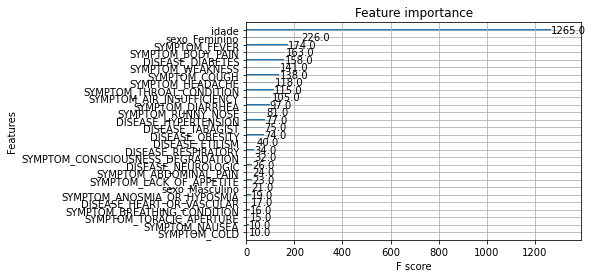

Início do período:  2021-02-20 00:00:00
Final do período:  2021-06-20 00:00:00
########################################

best_score: 0.8539670449104015
best_params_: {'colsample_bytree': 0.9, 'gamma': 1, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5628308721092227
########################################
"""Métricas f1_score:"""
f1:  0.5261250377529447
Macro:  0.560192076673214
Micro:  0.5628308721092227
weighted:  0.5628308721092227
########################################
"""Métricas precision_score:"""
Precision:  0.3935833709896069
Macro:  0.6143062203785243
Micro:  0.5628308721092227
weighted:  0.6999754678565856


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


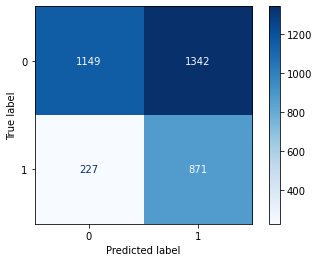

              precision    recall  f1-score   support

           0       0.84      0.46      0.59      2491
           1       0.39      0.79      0.53      1098

    accuracy                           0.56      3589
   macro avg       0.61      0.63      0.56      3589
weighted avg       0.70      0.56      0.57      3589

roc_auc_score:  0.627260505762457


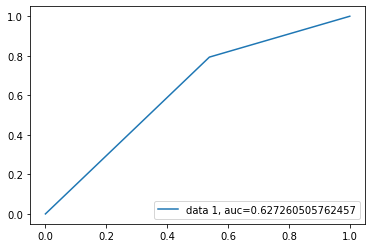

<Figure size 1008x1008 with 0 Axes>

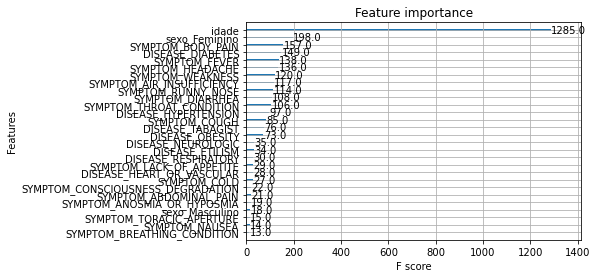

Início do período:  2021-03-22 00:00:00
Final do período:  2021-07-20 00:00:00
########################################

best_score: 0.848381371967179
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5548567435359888
########################################
"""Métricas f1_score:"""
f1:  0.5088666152659984
Macro:  0.5509189306361941
Micro:  0.5548567435359888
weighted:  0.5548567435359888
########################################
"""Métricas precision_score:"""
Precision:  0.3730921424533635
Macro:  0.6110657418579718
Micro:  0.5548567435359888
weighted:  0.7118428216896927


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


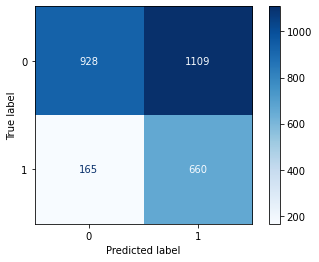

              precision    recall  f1-score   support

           0       0.85      0.46      0.59      2037
           1       0.37      0.80      0.51       825

    accuracy                           0.55      2862
   macro avg       0.61      0.63      0.55      2862
weighted avg       0.71      0.55      0.57      2862

roc_auc_score:  0.6277859597447226


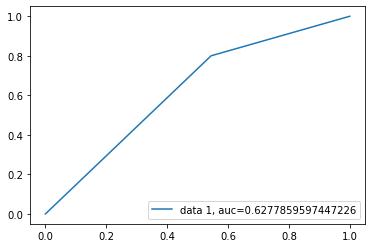

<Figure size 1008x1008 with 0 Axes>

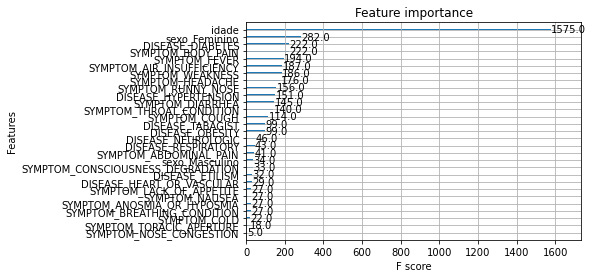

Início do período:  2021-04-21 00:00:00
Final do período:  2021-08-19 00:00:00
########################################

best_score: 0.8673323727639204
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5846242111302352
########################################
"""Métricas f1_score:"""
f1:  0.5452261306532663
Macro:  0.5814831814829162
Micro:  0.5846242111302352
weighted:  0.5846242111302352
########################################
"""Métricas precision_score:"""
Precision:  0.415311004784689
Macro:  0.6267099436530895
Micro:  0.5846242111302352
weighted:  0.7054236047693212


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


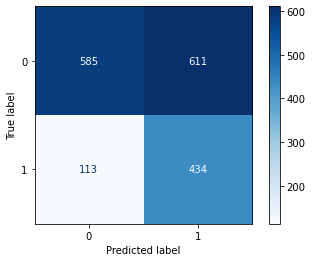

              precision    recall  f1-score   support

           0       0.84      0.49      0.62      1196
           1       0.42      0.79      0.55       547

    accuracy                           0.58      1743
   macro avg       0.63      0.64      0.58      1743
weighted avg       0.71      0.58      0.59      1743

roc_auc_score:  0.6412745409744853


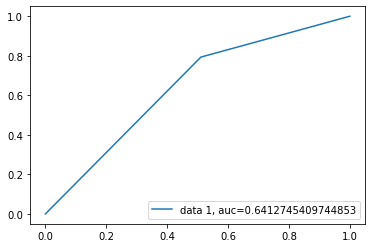

<Figure size 1008x1008 with 0 Axes>

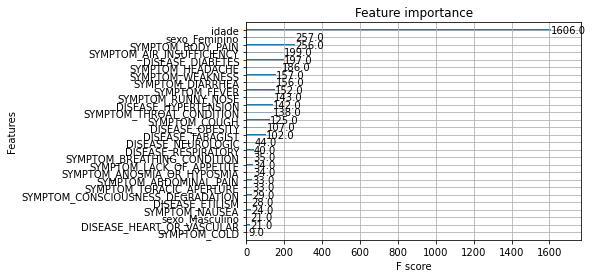

Início do período:  2021-05-21 00:00:00
Final do período:  2021-09-18 00:00:00
########################################

best_score: 0.8748043424857912
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5780701754385965
########################################
"""Métricas f1_score:"""
f1:  0.5449385052034058
Macro:  0.5758216647030929
Micro:  0.5780701754385965
weighted:  0.5780701754385965
########################################
"""Métricas precision_score:"""
Precision:  0.4186046511627907
Macro:  0.6197005556698909
Micro:  0.5780701754385965
weighted:  0.6906133219960789


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


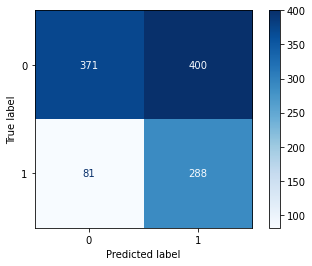

              precision    recall  f1-score   support

           0       0.82      0.48      0.61       771
           1       0.42      0.78      0.54       369

    accuracy                           0.58      1140
   macro avg       0.62      0.63      0.58      1140
weighted avg       0.69      0.58      0.59      1140

roc_auc_score:  0.6308405301951853


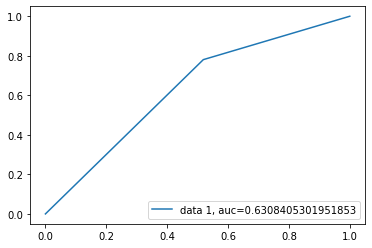

<Figure size 1008x1008 with 0 Axes>

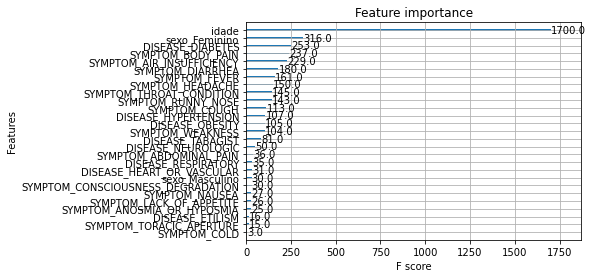

Início do período:  2021-06-20 00:00:00
Final do período:  2021-10-18 00:00:00
########################################

best_score: 0.8814412505718245
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5763157894736842
########################################
"""Métricas f1_score:"""
f1:  0.5126135216952573
Macro:  0.5689522224457668
Micro:  0.5763157894736842
weighted:  0.5763157894736842
########################################
"""Métricas precision_score:"""
Precision:  0.3762962962962963
Macro:  0.6214814814814815
Micro:  0.5763157894736842
weighted:  0.7307394411955815


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


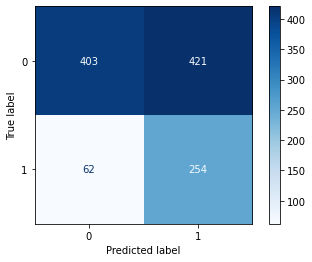

              precision    recall  f1-score   support

           0       0.87      0.49      0.63       824
           1       0.38      0.80      0.51       316

    accuracy                           0.58      1140
   macro avg       0.62      0.65      0.57      1140
weighted avg       0.73      0.58      0.59      1140

roc_auc_score:  0.6464375691286715


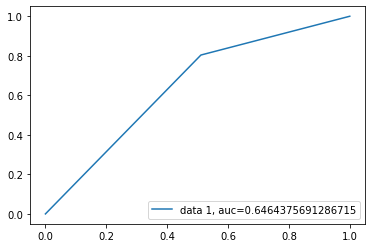

<Figure size 1008x1008 with 0 Axes>

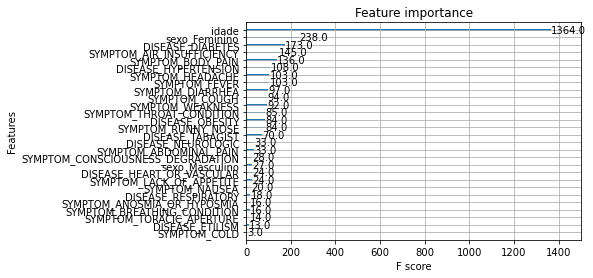

Início do período:  2021-07-20 00:00:00
Final do período:  2021-11-17 00:00:00
########################################

best_score: 0.8669125147405661
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5564892623716153
########################################
"""Métricas f1_score:"""
f1:  0.44703143189755534
Macro:  0.5384026995808899
Micro:  0.5564892623716153
weighted:  0.5564892623716153
########################################
"""Métricas precision_score:"""
Precision:  0.31735537190082647
Macro:  0.5921540808001986
Micro:  0.5564892623716153
weighted:  0.7366094245073384


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


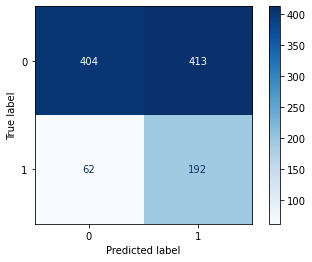

              precision    recall  f1-score   support

           0       0.87      0.49      0.63       817
           1       0.32      0.76      0.45       254

    accuracy                           0.56      1071
   macro avg       0.59      0.63      0.54      1071
weighted avg       0.74      0.56      0.59      1071

roc_auc_score:  0.6251987779373355


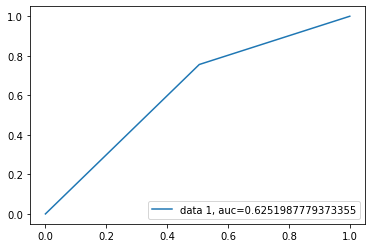

<Figure size 1008x1008 with 0 Axes>

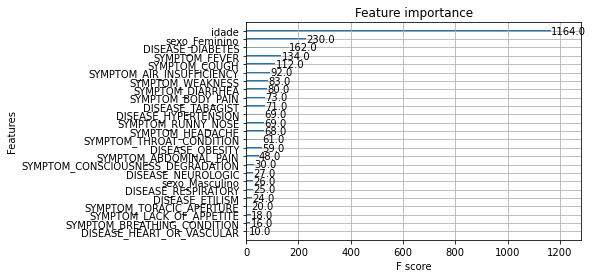

Início do período:  2021-08-19 00:00:00
Final do período:  2021-12-17 00:00:00
########################################

best_score: 0.9014736003641328
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5728952772073922
########################################
"""Métricas f1_score:"""
f1:  0.34591194968553457
Macro:  0.5144193894769137
Micro:  0.5728952772073922
weighted:  0.5728952772073922
########################################
"""Métricas precision_score:"""
Precision:  0.2570093457943925
Macro:  0.5387610831536065
Micro:  0.5728952772073922
weighted:  0.7001753228316777


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


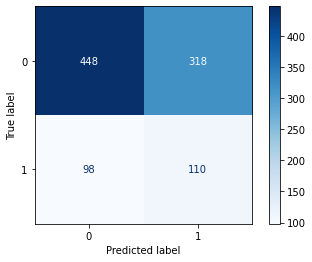

              precision    recall  f1-score   support

           0       0.82      0.58      0.68       766
           1       0.26      0.53      0.35       208

    accuracy                           0.57       974
   macro avg       0.54      0.56      0.51       974
weighted avg       0.70      0.57      0.61       974

roc_auc_score:  0.5568512753564974


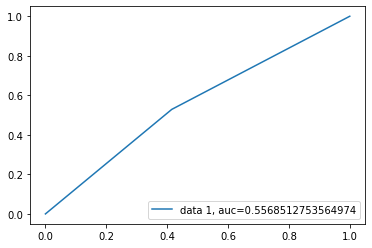

<Figure size 1008x1008 with 0 Axes>

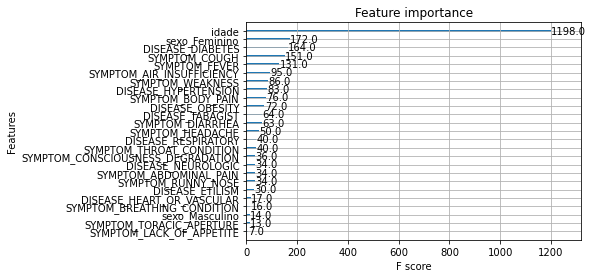

Início do período:  2021-09-18 00:00:00
Final do período:  2022-01-16 00:00:00
########################################

best_score: 0.9072791883788598
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.589527027027027
########################################
"""Métricas f1_score:"""
f1:  0.33546034639927075
Macro:  0.5192576681079857
Micro:  0.589527027027027
weighted:  0.589527027027027
########################################
"""Métricas precision_score:"""
Precision:  0.2647482014388489
Macro:  0.5315415382772413
Micro:  0.589527027027027
weighted:  0.6775568104658211


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


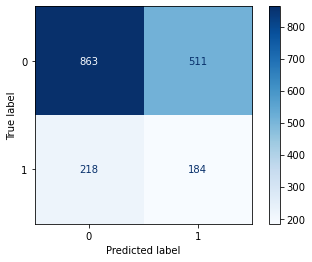

              precision    recall  f1-score   support

           0       0.80      0.63      0.70      1374
           1       0.26      0.46      0.34       402

    accuracy                           0.59      1776
   macro avg       0.53      0.54      0.52      1776
weighted avg       0.68      0.59      0.62      1776

roc_auc_score:  0.542902300723457


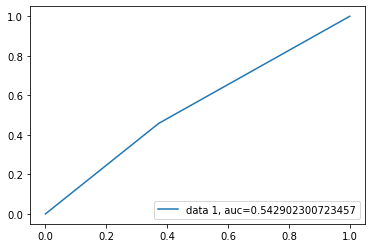

<Figure size 1008x1008 with 0 Axes>

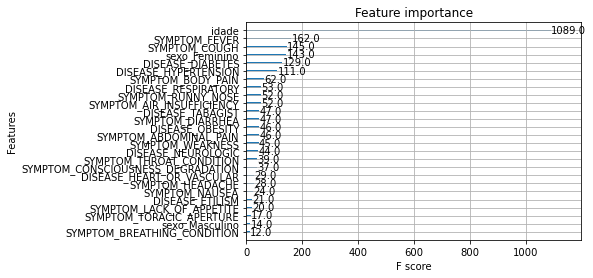

Início do período:  2021-10-18 00:00:00
Final do período:  2022-02-15 00:00:00
########################################

best_score: 0.9066583679240244
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6026258205689278
########################################
"""Métricas f1_score:"""
f1:  0.36235955056179775
Macro:  0.5368695400615727
Micro:  0.6026258205689278
weighted:  0.6026258205689278
########################################
"""Métricas precision_score:"""
Precision:  0.30034924330616997
Macro:  0.5425308628873066
Micro:  0.6026258205689278
weighted:  0.6649465174239423


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


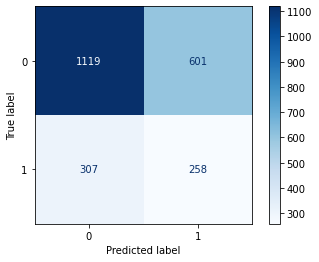

              precision    recall  f1-score   support

           0       0.78      0.65      0.71      1720
           1       0.30      0.46      0.36       565

    accuracy                           0.60      2285
   macro avg       0.54      0.55      0.54      2285
weighted avg       0.66      0.60      0.63      2285

roc_auc_score:  0.5536092817452151


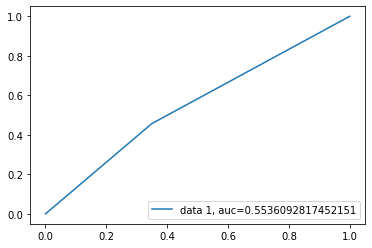

<Figure size 1008x1008 with 0 Axes>

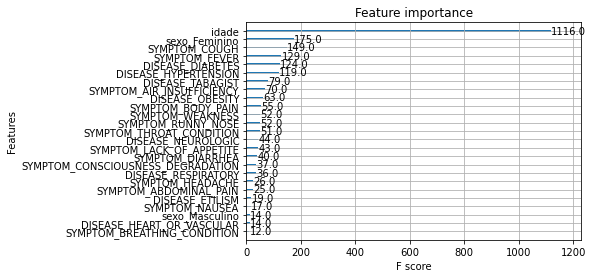

Início do período:  2021-11-17 00:00:00
Final do período:  2022-03-17 00:00:00
########################################

best_score: 0.8853634262205221
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5275437459494491
########################################
"""Métricas f1_score:"""
f1:  0.4218873909595559
Macro:  0.5112176680825177
Micro:  0.5275437459494491
weighted:  0.5275437459494491
########################################
"""Métricas precision_score:"""
Precision:  0.3275862068965517
Macro:  0.5386221048162649
Micro:  0.5275437459494491
weighted:  0.6268386661631314


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


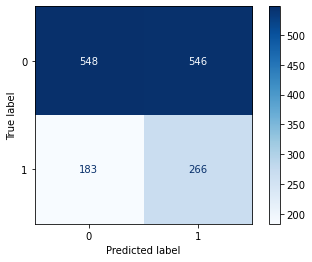

              precision    recall  f1-score   support

           0       0.75      0.50      0.60      1094
           1       0.33      0.59      0.42       449

    accuracy                           0.53      1543
   macro avg       0.54      0.55      0.51      1543
weighted avg       0.63      0.53      0.55      1543

roc_auc_score:  0.5466708468544765


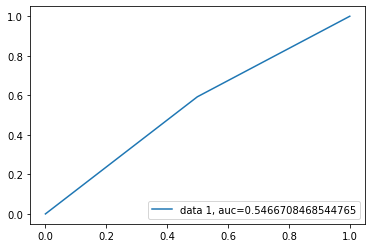

<Figure size 1008x1008 with 0 Axes>

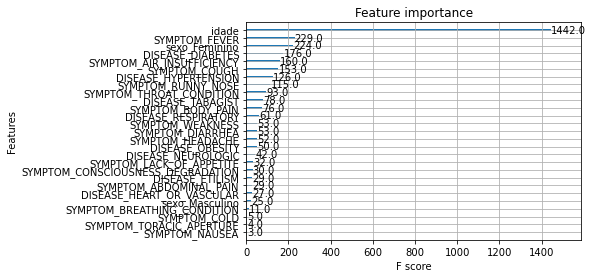

Início do período:  2021-12-17 00:00:00
Final do período:  2022-04-16 00:00:00
########################################

best_score: 0.8485481677356848
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5664739884393064
########################################
"""Métricas f1_score:"""
f1:  0.5243128964059197
Macro:  0.5630414039551723
Micro:  0.5664739884393064
weighted:  0.5664739884393064
########################################
"""Métricas precision_score:"""
Precision:  0.43205574912891986
Macro:  0.5824071849092876
Micro:  0.5664739884393064
weighted:  0.624992273656328


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


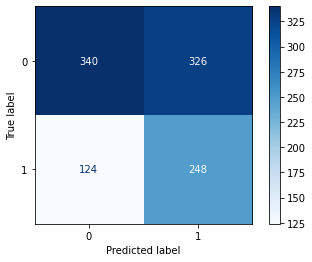

              precision    recall  f1-score   support

           0       0.73      0.51      0.60       666
           1       0.43      0.67      0.52       372

    accuracy                           0.57      1038
   macro avg       0.58      0.59      0.56      1038
weighted avg       0.62      0.57      0.57      1038

roc_auc_score:  0.5885885885885886


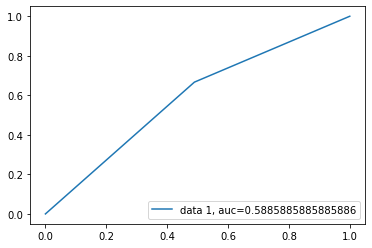

<Figure size 1008x1008 with 0 Axes>

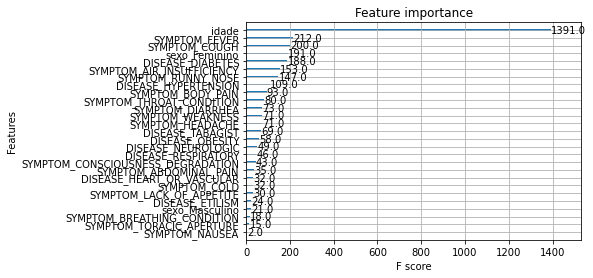

Início do período:  2022-01-16 00:00:00
Final do período:  2022-05-16 00:00:00
########################################

best_score: 0.8533535185185185
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6715945089757128
########################################
"""Métricas f1_score:"""
f1:  0.5891677675033025
Macro:  0.657820471262645
Micro:  0.6715945089757128
weighted:  0.6715945089757128
########################################
"""Métricas precision_score:"""
Precision:  0.5056689342403629
Macro:  0.6609372339186004
Micro:  0.6715945089757128
weighted:  0.7125840284261451


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


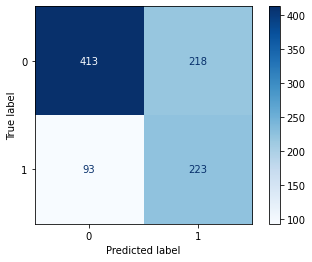

              precision    recall  f1-score   support

           0       0.82      0.65      0.73       631
           1       0.51      0.71      0.59       316

    accuracy                           0.67       947
   macro avg       0.66      0.68      0.66       947
weighted avg       0.71      0.67      0.68       947

roc_auc_score:  0.6801064213926057


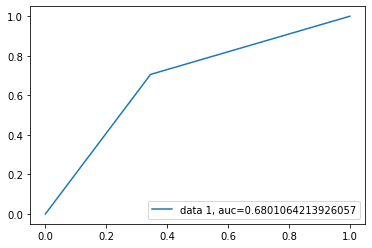

<Figure size 1008x1008 with 0 Axes>

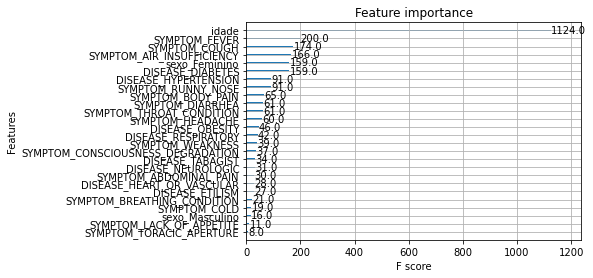

Início do período:  2022-02-15 00:00:00
Final do período:  2022-06-15 00:00:00
########################################

best_score: 0.8302757939587402
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.732183908045977
########################################
"""Métricas f1_score:"""
f1:  0.48565121412803525
Macro:  0.6523050165434271
Micro:  0.7321839080459769
weighted:  0.7321839080459769
########################################
"""Métricas precision_score:"""
Precision:  0.36423841059602646
Macro:  0.6460276560022387
Micro:  0.732183908045977
weighted:  0.8300004047272139


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


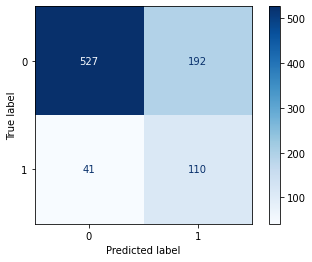

              precision    recall  f1-score   support

           0       0.93      0.73      0.82       719
           1       0.36      0.73      0.49       151

    accuracy                           0.73       870
   macro avg       0.65      0.73      0.65       870
weighted avg       0.83      0.73      0.76       870

roc_auc_score:  0.7307196345181405


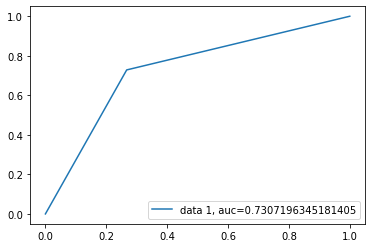

<Figure size 1008x1008 with 0 Axes>

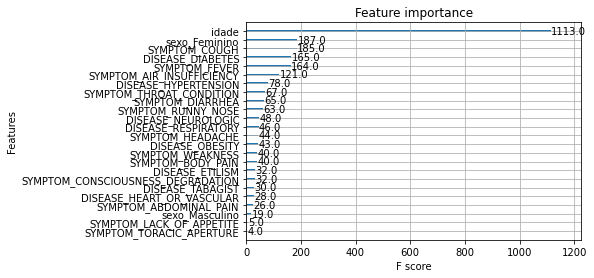

In [14]:
result_f1_120, result_precision_120 = apply_periodos(120, df)

In [10]:
result_f1_90

[[0.5637947725072604,
  0.6912042053503213,
  0.7437734561583077,
  0.7437734561583077],
 [0.5363048166786484,
  0.5924030895382343,
  0.6001239925604464,
  0.6001239925604464],
 [0.45507246376811594,
  0.5366086760275921,
  0.5509554140127388,
  0.5509554140127388],
 [0.44365192582025675,
  0.5854623265464919,
  0.6339746597841389,
  0.6339746597841389],
 [0.42718446601941745,
  0.600239687380506,
  0.6751548520302821,
  0.6751548520302821],
 [0.4447900466562986,
  0.5935141569021565,
  0.6479289940828402,
  0.6479289940828402],
 [0.43490701001430615,
  0.5840976643589424,
  0.6376146788990825,
  0.6376146788990825],
 [0.5340314136125655,
  0.6325746191929897,
  0.6590038314176245,
  0.6590038314176245],
 [0.5578342904019687,
  0.6212225869798025,
  0.6318306010928961,
  0.6318306010928961],
 [0.568760611205433,
  0.6346161546593203,
  0.6464857341684064,
  0.6464857341684064],
 [0.5565110565110565,
  0.6300617679928024,
  0.6446850393700787,
  0.6446850393700787],
 [0.546174142480211

In [11]:
metricas_f1_90 = pd.DataFrame(result_f1_90)
metricas_f1_90.columns = ['f1 score', 'f1 score macro', 'f1 score micro', 'f1 score weighted']
metricas_f1_90

f1 score  f1 score macro  f1 score micro  f1 score weighted
0   0.563795        0.691204        0.743773           0.743773
1   0.536305        0.592403        0.600124           0.600124
2   0.455072        0.536609        0.550955           0.550955
3   0.443652        0.585462        0.633975           0.633975
4   0.427184        0.600240        0.675155           0.675155
5   0.444790        0.593514        0.647929           0.647929
6   0.434907        0.584098        0.637615           0.637615
7   0.534031        0.632575        0.659004           0.659004
8   0.557834        0.621223        0.631831           0.631831
9   0.568761        0.634616        0.646486           0.646486
10  0.556511        0.630062        0.644685           0.644685
11  0.546174        0.630546        0.649813           0.649813
12  0.540865        0.584996        0.589689           0.589689
13  0.500633        0.549740        0.555096           0.555096
14  0.498164        0.563562        0.573361           0.573361
15  0.560857        0.599304        0.602993           0.602993
16  0.513433        0.582942        0.594527           0.594527
17  0.491935        0.563182        0.574803           0.574803
18  0.385093        0.543300        0.598106           0.598106
19  0.359202        0.536673        0.604651           0.604651
20  0.331787        0.530555        0.614716           0.614716
21  0.379139        0.529995        0.578415           0.578415
22  0.435666        0.504522        0.514091           0.514091
23  0.548485        0.609419        0.618926           0.618926
24  0.538793        0.643217        0.673780           0.673780
25  0.337349        0.585760        0.734727           0.734727

In [12]:
metricas_precision_90 = pd.DataFrame(result_precision_90)
metricas_precision_90.columns = ['precision score', 'precision score macro', 'precision score micro', 'precision score weighted']
metricas_precision_90

precision score  precision score macro  precision score micro  \
0          0.463399               0.681531               0.743773   
1          0.390303               0.647738               0.600124   
2          0.307441               0.619537               0.550955   
3          0.310379               0.615774               0.633975   
4          0.317117               0.606777               0.675155   
5          0.355721               0.597795               0.647929   
6          0.397906               0.582427               0.637615   
7          0.491329               0.630525               0.659004   
8          0.476190               0.628095               0.631831   
9          0.484104               0.640710               0.646486   
10         0.467010               0.636989               0.644685   
11         0.471168               0.632760               0.649813   
12         0.420299               0.619585               0.589689   
13         0.369701               0.603334               0.555096   
14         0.375461               0.602408               0.573361   
15         0.450000               0.625202               0.602993   
16         0.401869               0.607849               0.594527   
17         0.358824               0.612129               0.574803   
18         0.291536               0.561244               0.598106   
19         0.275510               0.550799               0.604651   
20         0.277132               0.534889               0.614716   
21         0.296248               0.545739               0.578415   
22         0.340388               0.533830               0.514091   
23         0.493188               0.611654               0.618926   
24         0.452899               0.643555               0.673780   
25         0.224599               0.589311               0.734727   

    precision score weighted  
0                   0.799293  
1                   0.766214  
2                   0.797948  
3                   0.806521  
4                   0.789185  
5                   0.724801  
6                   0.659622  
7                   0.676710  
8                   0.675202  
9                   0.691386  
10                  0.696883  
11                  0.689512  
12                  0.691865  
13                  0.702533  
14                  0.699469  
15                  0.681032  
16                  0.689832  
17                  0.732086  
18                  0.711244  
19                  0.707837  
20                  0.673336  
21                  0.673218  
22                  0.607335  
23                  0.641347  
24                  0.724932  
25                  0.881315

In [13]:
metricas_90 = pd.concat([metricas_f1_90, metricas_precision_90], axis=1)
metricas_90

f1 score  f1 score macro  f1 score micro  f1 score weighted  \
0   0.563795        0.691204        0.743773           0.743773   
1   0.536305        0.592403        0.600124           0.600124   
2   0.455072        0.536609        0.550955           0.550955   
3   0.443652        0.585462        0.633975           0.633975   
4   0.427184        0.600240        0.675155           0.675155   
5   0.444790        0.593514        0.647929           0.647929   
6   0.434907        0.584098        0.637615           0.637615   
7   0.534031        0.632575        0.659004           0.659004   
8   0.557834        0.621223        0.631831           0.631831   
9   0.568761        0.634616        0.646486           0.646486   
10  0.556511        0.630062        0.644685           0.644685   
11  0.546174        0.630546        0.649813           0.649813   
12  0.540865        0.584996        0.589689           0.589689   
13  0.500633        0.549740        0.555096           0.555096   
14  0.498164        0.563562        0.573361           0.573361   
15  0.560857        0.599304        0.602993           0.602993   
16  0.513433        0.582942        0.594527           0.594527   
17  0.491935        0.563182        0.574803           0.574803   
18  0.385093        0.543300        0.598106           0.598106   
19  0.359202        0.536673        0.604651           0.604651   
20  0.331787        0.530555        0.614716           0.614716   
21  0.379139        0.529995        0.578415           0.578415   
22  0.435666        0.504522        0.514091           0.514091   
23  0.548485        0.609419        0.618926           0.618926   
24  0.538793        0.643217        0.673780           0.673780   
25  0.337349        0.585760        0.734727           0.734727   

    precision score  precision score macro  precision score micro  \
0          0.463399               0.681531               0.743773   
1          0.390303               0.647738               0.600124   
2          0.307441               0.619537               0.550955   
3          0.310379               0.615774               0.633975   
4          0.317117               0.606777               0.675155   
5          0.355721               0.597795               0.647929   
6          0.397906               0.582427               0.637615   
7          0.491329               0.630525               0.659004   
8          0.476190               0.628095               0.631831   
9          0.484104               0.640710               0.646486   
10         0.467010               0.636989               0.644685   
11         0.471168               0.632760               0.649813   
12         0.420299               0.619585               0.589689   
13         0.369701               0.603334               0.555096   
14         0.375461               0.602408               0.573361   
15         0.450000               0.625202               0.602993   
16         0.401869               0.607849               0.594527   
17         0.358824               0.612129               0.574803   
18         0.291536               0.561244               0.598106   
19         0.275510               0.550799               0.604651   
20         0.277132               0.534889               0.614716   
21         0.296248               0.545739               0.578415   
22         0.340388               0.533830               0.514091   
23         0.493188               0.611654               0.618926   
24         0.452899               0.643555               0.673780   
25         0.224599               0.589311               0.734727   

    precision score weighted  
0                   0.799293  
1                   0.766214  
2                   0.797948  
3                   0.806521  
4                   0.789185  
5                   0.724801  
6                   0.659622  
7                   0.676710  
8                   0.675202  
9                   

In [15]:
metricas_f1_120 = pd.DataFrame(result_f1_120)
metricas_f1_120.columns = ['f1 score', 'f1 score macro', 'f1 score micro', 'f1 score weighted']
#metricas_f1_120
metricas_precision_120 = pd.DataFrame(result_precision_120)
metricas_precision_120.columns = ['precision score', 'precision score macro', 'precision score micro', 'precision score weighted']
#metricas_precision_90
metricas_120 = pd.concat([metricas_f1_120, metricas_precision_120], axis=1)
metricas_120


f1 score  f1 score macro  f1 score micro  f1 score weighted  \
0   0.574468        0.659574        0.680851           0.680851   
1   0.491090        0.555836        0.565273           0.565273   
2   0.450679        0.556447        0.581668           0.581668   
3   0.451310        0.579710        0.618937           0.618937   
4   0.451613        0.576375        0.613119           0.613119   
5   0.461220        0.592267        0.634386           0.634386   
6   0.490441        0.608084        0.643397           0.643397   
7   0.554622        0.621921        0.633900           0.633900   
8   0.572655        0.622789        0.629452           0.629452   
9   0.576830        0.639286        0.650100           0.650100   
10  0.566249        0.620414        0.628144           0.628144   
11  0.551451        0.629740        0.646294           0.646294   
12  0.526125        0.560192        0.562831           0.562831   
13  0.508867        0.550919        0.554857           0.554857   
14  0.545226        0.581483        0.584624           0.584624   
15  0.544939        0.575822        0.578070           0.578070   
16  0.512614        0.568952        0.576316           0.576316   
17  0.447031        0.538403        0.556489           0.556489   
18  0.345912        0.514419        0.572895           0.572895   
19  0.335460        0.519258        0.589527           0.589527   
20  0.362360        0.536870        0.602626           0.602626   
21  0.421887        0.511218        0.527544           0.527544   
22  0.524313        0.563041        0.566474           0.566474   
23  0.589168        0.657820        0.671595           0.671595   
24  0.485651        0.652305        0.732184           0.732184   

    precision score  precision score macro  precision score micro  \
0          0.443546               0.674248               0.680851   
1          0.339174               0.635442               0.565273   
2          0.302552               0.625002               0.581668   
3          0.309963               0.622434               0.618937   
4          0.330556               0.603262               0.613119   
5          0.393298               0.593502               0.634386   
6          0.457364               0.606243               0.643397   
7          0.477728               0.627076               0.633900   
8          0.463754               0.642060               0.629452   
9          0.476000               0.650450               0.650100   
10         0.459358               0.638307               0.628144   
11         0.471251               0.633743               0.646294   
12         0.393583               0.614306               0.562831   
13         0.373092               0.611066               0.554857   
14         0.415311               0.626710               0.584624   
15         0.418605               0.619701               0.578070   
16         0.376296               0.621481               0.576316   
17         0.317355               0.592154               0.556489   
18         0.257009               0.538761               0.572895   
19         0.264748               0.531542               0.589527   
20         0.300349               0.542531               0.602626   
21         0.327586               0.538622               0.527544   
22         0.432056               0.582407               0.566474   
23         0.505669               0.660937               0.671595   
24         0.364238               0.646028               0.732184   

    precision score weighted  
0                   0.782996  
1                   0.791984  
2                   0.822117  
3                   0.816854  
4                   0.754036  
5                   0.681311  
6                   0.658467  
7                   0.673419  
8                   0.702064  
9                   0.711210  
10                  0.699541  
11                  0.689907  
12                  0.699975  
13                  0.711843  
1